# Final version for ball detection

* all old versions are in backup_notebooks.py or detect_ball_thresh.py
* this version: employ metric including area differences, slope, distance, angle diagonals of rectangle
* search in graph for moment when this metric is smaller the threshold

In [109]:
import cv2
import math
from matplotlib import pyplot as plt
import numpy as np
import os
import time
import json
%matplotlib inline

def from_json(file):
    coordinates = ["x", "y"]
    joints_list = ["right_shoulder", "right_elbow", "right_wrist", "left_shoulder","left_elbow", "left_wrist",
            "right_hip", "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle",
            "right_eye", "right_ear","left_eye", "left_ear", "nose ", "neck"]
    with open(file, 'r') as inf:
        out = json.load(inf)

    liste = []
    for fr in out["frames"]:
        l_joints = []
        for j in joints_list[:12]:
            l_coo = []
            for xy in coordinates:
                l_coo.append(fr[j][xy])
            l_joints.append(l_coo)
        liste.append(l_joints)

    return np.array(liste)

class Node():
    def __init__(self, x1, y1, x2, y2):
        self.bbox = [x1, y1, x2, y2]
        self.l = abs(x1-x2)
        self.w = abs(y1-y2)
        self.angle = np.arctan(self.l/self.w)
        self.area = self.l*self.w # (l+w)/float(l*w)
        self.center = np.array([(x1+x2)/2, (y1+y2)/2])
        self.children = []
        self.area_diffs = []
        self.angle_diffs = []
        self.slopes = []
        self.dist = []
    def add_child(self, no):
        dist = np.linalg.norm(no.center-self.center)
        if dist>10: 
            self.children.append(no)
            self.area_diffs.append(abs(1-(no.area/self.area)))
            y_diff = (self.center[1]-no.center[1])
            slope = np.arctan(y_diff/(self.center[0]-no.center[0]))
            if y_diff<0:
                slope+=np.pi
            self.slopes.append(slope)
            self.dist.append(dist)
            self.angle_diffs.append(abs(self.angle-no.angle))
    def favourite_child(self, no):
        self.fav_child=no
        

In [128]:
def get_difference(im_tm1, im_t, im_tp1):
    """
    calculates difference image and applies threshold to detect significant motion
    parameters: three consecutive frames
    returns binary image of same size as input frames indicating significantly different pixels
    """
    delta_plus = cv2.absdiff(im_t, im_tm1)
    delta_0 = cv2.absdiff(im_tp1, im_tm1)
    delta_minus = cv2.absdiff(im_t,im_tp1)
    sp = cv2.meanStdDev(delta_plus)
    sm = cv2.meanStdDev(delta_minus)
    s0 = cv2.meanStdDev(delta_0)
    # print("E(d+):", sp, "\nE(d-):", sm, "\nE(d0):", s0)

    th = [
        sp[0][0, 0] + 3 * math.sqrt(sp[1][0, 0]),
        sm[0][0, 0] + 3 * math.sqrt(sm[1][0, 0]),
        s0[0][0, 0] + 3 * math.sqrt(s0[1][0, 0]),
    ]

    # OPENCV THRESHOLD

    ret, dbp = cv2.threshold(delta_plus, th[0], 255, cv2.THRESH_BINARY)
    ret, dbm = cv2.threshold(delta_minus, th[1], 255, cv2.THRESH_BINARY)
    ret, db0 = cv2.threshold(delta_0, th[2], 255, cv2.THRESH_BINARY)

    detect = cv2.bitwise_and(cv2.bitwise_and(dbp, dbm), cv2.bitwise_not(db0))
    # nd = cv2.bitwise_not(detect)
    return detect


def get_candidates(nd, min_area):
    """
    find connected components in a binary difference image
    nd is a binary image indicating significant pixel changes
    min_area is the minimum area of pixels in nd that should be recognized as a connected region
    return list of candidates, each is a tuple (left_top_corner, right_bottom_corner, area)
    """
    # only stats is used, not num, labels, centroids
    num, labels, stats, centroids = cv2.connectedComponentsWithStats(nd, ltype=cv2.CV_16U)
    # We set an arbitrary threshold to screen out smaller "components"
    # which may result simply from noise, or moving leaves, and other
    # elements not of interest.
    candidates = list()
    for stat in stats[1:]:
        area = stat[cv2.CC_STAT_AREA]
        if area < min_area:
            continue # Skip small objects (noise)

        lt = (stat[cv2.CC_STAT_LEFT], stat[cv2.CC_STAT_TOP])
        rb = (lt[0] + stat[cv2.CC_STAT_WIDTH], lt[1] + stat[cv2.CC_STAT_HEIGHT])
        #if np.any(np.array(lt)==0) or np.any(np.array(rb)==0):
         #   continue
        bottomLeftCornerOfText = (lt[0], lt[1] - 15)

        candidates.append((lt, rb, area))
    return candidates


def first_movement(cand_list, joints, ankle_move, fr):
    knees= joints[[7, 10],:]
    ankles = joints[[8,11],:]
    #print(knees, ankles, knees-ankles, np.mean(knees-ankles, axis=0))
    dist_ankle = np.linalg.norm(np.mean(knees-ankles, axis=0)) #//2
    #print("radius", dist_ankle)
    for k, cand in enumerate(cand_list):
        x1, y1 = cand[0]
        x2, y2 = cand[1]
        center = [(x1+x2)/2, (y1+y2)/2]
              #np.linalg.norm(cand.center - knees[0]), 
            #np.linalg.norm(cand.center - knees[1]), np.linalg.norm(cand.center - ankles[1]), 
                #                                     np.linalg.norm(cand.center - ankles[0]))
        #print(np.linalg.norm(cand.center - knees[0])<radius, np.linalg.norm(cand.center - knees[1])<radius)
        norms = np.array([np.linalg.norm(center - knees[0]), np.linalg.norm(center - knees[1]), np.linalg.norm(center - ankles[0]), np.linalg.norm(center - ankles[1])])
        #print("center", cand.center, "knees", knees[0],knees[1], "ankles", ankles, "norms", norms)
        if np.any(norms<dist_ankle):
            print("smaller radius", center)
            ankle_move.append(fr) #cand.center)
            break
    return ankle_move
        #if k==len(candidates_per_frame[-1])-1:
         #   ankle_move=[]
    #print(t, ankle_move)

def plot(im_t, candidates, frame_nr):
    #print("DETECTED", t-1, whiteness_values[-1], candidate_values[-1])
    plt.figure(figsize=(10, 10), edgecolor='r')
    # print(candidates[fom])
    img = np.tile(np.expand_dims(im_t.copy(), axis = 2), (1,1,3))
    #print(img.shape)
    #for jo in ankles:
     #   cv2.circle(img, (int(jo[0]), int(jo[1])), 8, [255,0,0], thickness=-1)
    #for kn in knees:
     #   cv2.circle(img, (int(kn[0]), int(kn[1])), 8, [255,0,0], thickness=-1)
    for can in candidates: # einfuegen falls alles plotten
        cv2.rectangle(img, can[0], can[1],[255,0,0], 4)
    #cv2.rectangle(img,tuple(balls[-1][:2]), tuple(balls[-1][2:]), [255,0,0], 4)
    plt.imshow(img, 'gray')
    plt.title("Detected FOM frame"+ str(frame_nr))
    plt.show()


def add_candidate(candidate, candidates_per_frame):
    # The first two elements of each `candidate` tuple are
    # the opposing corners of the bounding box.
    x1, y1 = candidate[0]
    x2, y2 = candidate[1]
    no = Node(x1, y1, x2, y2)
    #print("area_cand[3]:", candidate[2], "area node", no.area)
    candidates_per_frame[-1].append(no)
    if candidates_per_frame[-2]!=[]:
        for nodes_in in candidates_per_frame[-2]:
            nodes_in.add_child(no)
            # print("previous detection", nodes.bbox, "gets child", no.bbox)
    return candidates_per_frame

def ball_detection(candidates_per_frame, balls, metric_thresh =0.5):
    if len(balls)==0:
        for cands3 in candidates_per_frame[-3]:
            for j, cands2 in enumerate(cands3.children): # counts through children (ebene 2)
                slope = cands3.slopes[j] # slope of 3 to 2
                dist = cands3.dist[j]
                area = cands3.area_diffs[j]
                angle = cands3.angle_diffs[j]
                print("j", j, slope, dist, area, angle)
                for k, cands1 in enumerate(cands2.children):
                    print("k", k, cands2.slopes[k], cands2.dist[k], cands2.area_diffs[k], cands2.angle_diffs[k])
                    print("metric: ", abs(slope-cands2.slopes[k]), abs(1- dist/cands2.dist[k]), area, cands2.area_diffs[k])
                    metric = abs(slope-cands2.slopes[k]) + abs(1- dist/cands2.dist[k]) #+ area+cands2.area_diffs[k] + angle + cands2.angle_diffs[k] 
                    if metric<metric_thresh:
                        balls = [cands3, cands2, cands1]
                    # if abs(slope-cands2.slopes[k]) < 0.1 and abs(dist-cands2.dist[k])<10:
                        return balls
    else:
        j = balls[-2].children.index(balls[-1])
        slope = balls[-2].slopes[j] # slope of 3 to 2
        dist = balls[-2].dist[j]
        area = balls[-2].area_diffs[j]
        angle = balls[-2].angle_diffs[j]
        for k, cands1 in enumerate(balls[-1].children):
            print("k", k, balls[-1].slopes[k], balls[-1].dist[k], balls[-1].area_diffs[k], balls[-1].angle_diffs[k])
            print("metric: ", abs(slope-balls[-1].slopes[k]), abs(1- dist/balls[-1].dist[k]), area, balls[-1].area_diffs[k])
            metric = abs(slope-balls[-1].slopes[k]) + abs(1- dist/balls[-1].dist[k]) # + area+balls[-1].area_diffs[k] + angle + balls[-1].angle_diffs[k] 
            if metric<metric_thresh:
                balls.append(cands1)
            # if abs(slope-cands2.slopes[k]) < 0.1 and abs(dist-cands2.dist[k])<10:
                return balls
    return []

def distance_projected(p, p1,p2):
    """
    returns distance of p' (= p projected on line spanned by p1 and p2) from p1
    """
    v1 = p-p1
    v2 = p2-p1
    v1_u = v1 / np.linalg.norm(v1)
    v2_u = v2 / np.linalg.norm(v2)
    return np.clip(np.dot(v1_u, v2_u), -1.0, 1.0) * np.linalg.norm(v1)

def _get_max_array(array_list):
    resultant_array = np.zeros(array_list[0].shape)
    for array in array_list:
        resultant_array = np.maximum(resultant_array, array)
    return resultant_array

def trajectory_and_speed(balls, im_t, t, fps = 30, factor_pixel_feet=10, plotting=True):
    #plot(im_t, candidates, t)
    trajectory = np.array([elem.center for elem in balls]).astype(int)
    print("trajectory", trajectory.tolist())
    # distance
    dist_from_start = distance_projected(trajectory[0], np.array([110, 140]),np.array([690, 288]))
    speed = np.mean([np.linalg.norm(trajectory[i]- trajectory[i+1]) for i in range(len(trajectory)-1)])
    frames_shifted = dist_from_start/speed + len(balls)-1 # frames because current frame is already after nth ball detection
    print("frames from release frame (using distance from center of base projected)", frames_shifted)
    #plt.scatter(trajectory[:,0], trajectory[:,1])
    #plt.show()
    first_move_frame = round(t - frames_shifted)
    if plotting:
        plt.figure(figsize=(10, 10), edgecolor='r')
        img = np.tile(np.expand_dims(im_t.copy(), axis = 2), (1,1,3))
        img = cv2.line(img, (110, 140),(690, 288), color = 2)
        for i in range(len(trajectory)-1):
            img = cv2.line(img, tuple(trajectory[i]),tuple(trajectory[i+1]), color = 2)
        #img = cv2.line(img, tuple(trajectory[1]),tuple(trajectory[2]), color = 2)
        plt.imshow(img, 'gray')
        plt.title("Ball trajectory")
        plt.show()
        print("RELEASE FRAME AT ", first_move_frame, "SPEED in mph", speed*fps* 0.681818 /factor_pixel_feet) # 1 ft/s = 0.681818 mph
        print("")
    return first_move_frame

In [129]:
def detect_ball(folder, joints_array=None, min_area = 400, plotting=True, min_length_first=5, min_length_ball=3, every_x_frame=1):
    fps = 30
    factor_pixel_feet = 10
    cap = cv2.VideoCapture(folder)
    images=[]
    motion_images=[]
    start = time.time()

    candidates_per_frame = []
    location = []
    frame_indizes = []
    ankle_move=[]
    balls = []
    t=0
    # temp=0
    frame_before_close_wrist = False
    first_move_found = False
    while t<300:
        ret, frame = cap.read()
        if frame is None:
            first_move_frame = 0
            break
        #if temp%every_x_frame !=0:
         #   temp+=1
        #  continue
        #temp+=1
              
        candidates_per_frame.append([])
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)[400:800, 600:1400]
        """ 
        print(2)
        row,col= frame.shape
        mean = 0
        var = 500
        sigma = var**0.5
        print(3)
        gauss = np.random.normal(mean,sigma,(row,col))
        print(4)
        gaussframe = gauss.reshape(row,col) + frame
        gaussframe[gaussframe>255]=255
        gaussframe[gaussframe<0]=0
        frame = np.array(gaussframe.astype(np.uint8))
        """
    # for t in range(1, length-1):
        if first_move_found and joints_array is not None:
            if first_move_frame+2 >= t:
                print(first_move_frame, t)
                images = np.roll(np.array(images), -1, axis=0)
                images[-1] = frame
                t+=1
                continue
            else:
                diff = t-first_move_frame
                try:
                    show_frames = [images[-diff], images[-diff+1], images[-diff+2]]
                except IndexError:
                    print("PROBLEM: NOT ENOUGH FRAMES SAVED")
                    show_frames = [images[0], images[1], images[2]]
                    diff = 10
                fig = plt.figure(figsize=(10, 5))
                for ind, i in enumerate(show_frames):
                    ax = fig.add_subplot(1,len(show_frames),ind+1)
                    plt.imshow(i[100:400, 200:600])
                    plt.title("frame "+str(t-diff+ind))
                    plt.grid(False)
                    plt.axis('off')
                    plt.gray()
                plt.tight_layout()
                #plt.show()
                plt.savefig("qualitative_first_move_3_refined/"+folder.split("/")[-1][:-4]+".png")
                break
                       
        if t>1:
            im_tm1 = images[-2]
            im_t = images[-1]
            im_tp1 = frame

            nd = get_difference(im_tm1, im_t, im_tp1)
            if t<11:
                motion_images.append(nd)
        if t<11:
            images.append(frame)
            t+=1
            continue
        im_every_x_0 = images[-2*every_x_frame]
        im_every_x_1 = images[-every_x_frame]
        im_every_x_2 = images[-1]

        cumulative_motion = _get_max_array(motion_images)
        final_frame = nd.astype(int) - cumulative_motion.astype(int)
        final_frame[final_frame < 0] = 0
        candidates = get_candidates(final_frame.astype(np.uint8), min_area)

        # NORMAL CANDIDATES (THREE IN A ROW)
        # candidates = get_candidates(im_tm1, im_t, im_tp1, min_area)
        #plt.figure(figsize=(10, 10), edgecolor='k')
            
        ### HERE INSERT RELEASE FRAME CLOSE TO WRIST
        for i, candidate in enumerate(candidates):
            if t>0:
                candidates_per_frame = add_candidate(candidate, candidates_per_frame)
            ### HERE INSERT CLOSE TO WRIST
            ### HERE INSERT SHORTEST PATH CODE
            #save location of candidate and frame
            #location.append(center)
            frame_indizes.append(t-1)
       
        ### BALL DETECTION:
        l = np.array([len(candidates_per_frame[-i-1]) for i in range(3)])
        if np.all(l>0) and len(balls)==0:
            balls = ball_detection(candidates_per_frame, balls)
            if len(balls)==3:
                first_move_frame = trajectory_and_speed(balls, im_t, t, plotting = False)
                counter = 0
        elif len(balls)>0:
            if len(candidates_per_frame)>0:
                new_balls = ball_detection(candidates_per_frame, balls)
                if len(new_balls)==0 and counter>-1: # change from -1 to higher number to allow missing balls 
                    # inbetween (problem: speed then calculated wrong because len(balls))
                    # problem 2: dist in metric - also there some number indicating this
                    # general problem: candidates not in balls[-1].children
                    first_move_frame = trajectory_and_speed(balls, im_t, t-1)
                    break
                else:
                    balls = new_balls 
            else:
                first_move_frame = trajectory_and_speed(balls, im_t, t-1)
                break
        else:
            balls=[]
        
        # FIRST MOVEMENT --> SHIFtED CANDIDATES
        
        if not first_move_found and joints_array is not None:
        # SHIFTED CANDIDATES:
            detected_moves = get_difference(im_every_x_0, im_every_x_1, im_every_x_2)
            shifted_candidates = get_candidates(detected_moves, min_area)
            #plt.figure(figsize=(10, 10), edgecolor='k')

            ### FIRST MOVEMENT:
            if shifted_candidates!=[]:
                ankle_move = first_movement(shifted_candidates, joints_array[t-every_x_frame], ankle_move, t)
            if len(ankle_move)>=min_length_first and t-ankle_move[-min_length_first]<10: #len(ankle_move)==3:
                print("first movement frame: ", (ankle_move[-min_length_first]))
                plot(im_t, shifted_candidates, t)
                first_move_found=True
                first_move_frame = ankle_move[-min_length_first]
                range_joints = joints[first_move_frame -10: first_move_frame +10]
                grad = range_joints # np.gradient(range_joints, axis = 0) # OHNE GRADIENT; JUST HEIGHT OF LEG
                plt.plot(grad[:,:,1])
                mean_gradient = np.mean(grad[:, [7,8,10,11],1], axis = 1)
                plt.plot(mean_gradient, c="black")
                plt.show()
                first_move_frame = first_move_frame-10+np.argmin(mean_gradient)
                print("refined first movement", first_move_frame)

        if plotting and len(candidates)>0: #len(balls)>0: # ##
            plot(im_t, candidates, t)
            #plt.imshow(cumulative_motion.astype(int))
            #plt.show()

        t+=1
        images = np.roll(np.array(images), -1, axis=0)
        images[-1] = frame
        motion_images = np.roll(np.array(motion_images), -1, axis=0)
        motion_images[-1] = nd
    # print("time for %s frames"%t, (time.time() - start) * 1000)

    return frame_indizes, location, candidates_per_frame, first_move_frame

# 40mph_1us_1.2f_170fps_40m_sun # 40mph_10us_6f_100fps_40m_cloudy # 40mph_10us_11f_100fps_noisy.avi


video: 490770-1c3452eb-5fc2-47bb-aff4-91a6fcfe493f.m4v
j 0 3.39526674973 41.8389770429 0.4140625 0.141897054604
k 0 3.39448671869 45.9619407771 0.253333333333 0.0434508953915
metric:  0.000780031043045 0.0897038650777 0.4140625 0.253333333333
trajectory [[167, 116], [207, 126], [252, 138]]
frames from release frame (using distance from center of base projected) 3.12287578628
k 0 3.37844141454 44.7493016705 0.0178571428571 0.148327834122
metric:  0.0160453041487 0.02709850347 0.253333333333 0.0178571428571
trajectory [[167, 116], [207, 126], [252, 138], [295, 148]]
frames from release frame (using distance from center of base projected) 4.12078501657


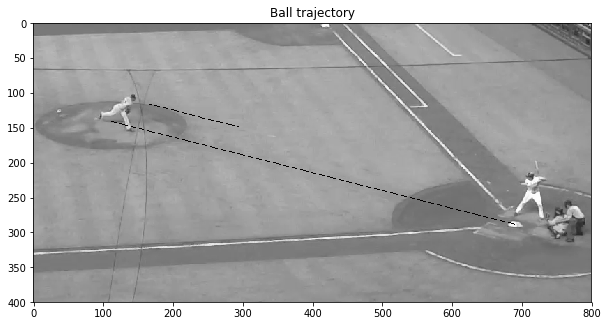

RELEASE FRAME AT  94.0 SPEED in mph 89.9666081368

video: 490770-1ccdbdae-0b31-49ab-a08c-a4ceded9e778.m4v
j 0 3.39230191301 42.3231615076 0.25 0.237534631896
k 0 3.37008929288 44.1474801093 0.2 0.0767718912698
metric:  0.0222126201295 0.0413232781838 0.25 0.2
trajectory [[186, 120], [227, 131], [270, 141]]
frames from release frame (using distance from center of base projected) 3.58654416569
k 0 3.44516339291 43.4885042281 0.277777777778 0.165148677415
metric:  0.0750741000318 0.015152875291 0.2 0.277777777778
k 0 3.3810919195 44.2634160453 0.0576923076923 0.128128561541
metric:  0.0640714734135 0.0175068236122 0.277777777778 0.0576923076923
k 0 3.43199459614 45.4009911786 0.0909090909091 0.0318363734271
metric:  0.0509026766383 0.0250561739682 0.0576923076923 0.0909090909091
trajectory [[186, 120], [227, 131], [270, 141], [311, 154], [354, 164], [398, 177]]
frames from release frame (using distance from center of base projected) 6.56383922838


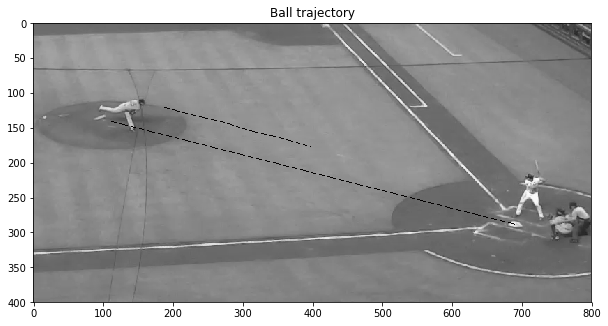

RELEASE FRAME AT  98.0 SPEED in mph 89.8514089877

video: 490770-1f118855-f077-4e0a-9f95-71ea49ea4d32.m4v
j 0 2.20786665607 31.1006430802 1.03076923077 0.374773434188
j 0 4.31386653472 10.307764064 1.0625 0.0434508953915
j 0 -0.00775178271221 129.003875911 0.615384615385 0.430585730821
k 0 3.3802019761 38.0788655293 0.166666666667 0.068856489301
metric:  3.38795375881 2.38780775418 0.615384615385 0.166666666667
j 0 3.3802019761 38.0788655293 0.166666666667 0.068856489301
k 0 3.42833805772 40.6601770778 0.44 0.0
metric:  0.0481360816237 0.0634850050841 0.166666666667 0.44
trajectory [[290, 132], [327, 141], [366, 153]]
frames from release frame (using distance from center of base projected) 6.3718600162
k 0 3.45176071438 40.9542427595 0.0277777777778 0.12062366858
metric:  0.023422656656 0.00718034718292 0.44 0.0277777777778
k 0 3.44447752196 41.9076365356 0.428571428571 0.0374824366917
metric:  0.00728319241301 0.022749881763 0.0277777777778 0.428571428571
trajectory [[290, 132], [327,

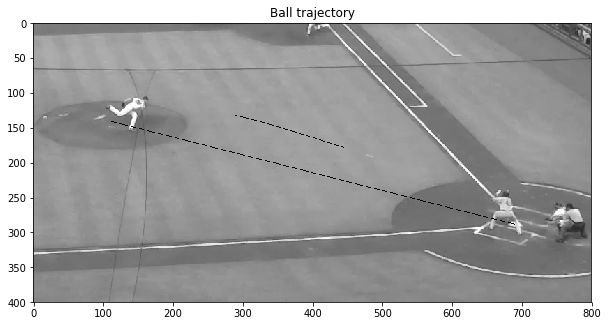

RELEASE FRAME AT  101.0 SPEED in mph 82.7115991051

video: 490770-2065dfd4-7a7e-4889-a6a5-ee941aa2f62f.m4v
j 0 0.253599139239 478.298024248 0.152380952381 0.348771003584
k 0 3.40385406057 582.41501526 0.0743801652893 0.3729877218
metric:  3.15025492133 0.17876769706 0.152380952381 0.0743801652893
j 0 0.428264152877 25.2833937595 0.314285714286 0.0327751444041
k 0 0.396441283218 23.3077240416 0.833333333333 0.0147048223779
metric:  0.0318228696582 0.084764591961 0.314285714286 0.833333333333
trajectory [[735, 223], [712, 213], [690, 204]]
frames from release frame (using distance from center of base projected) 27.6344608774
trajectory [[735, 223], [712, 213], [690, 204]]
frames from release frame (using distance from center of base projected) 27.6344608774


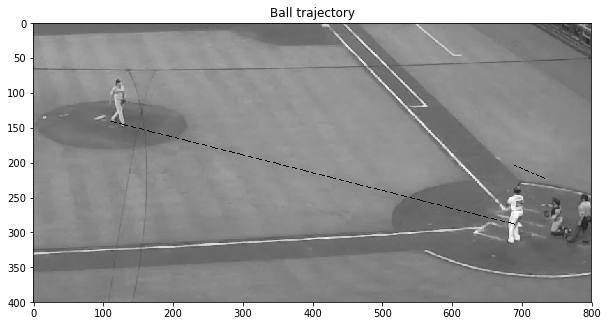

RELEASE FRAME AT  140.0 SPEED in mph 49.9598059392

video: 490770-20d18884-c48b-4a6f-9870-bdf54ece8321.m4v
j 0 3.39448671869 45.9619407771 0.0888888888889 0.0831412318884
k 0 3.37584786718 45.2354949127 0.142857142857 0.0587558227157
metric:  0.0186388515013 0.0160592000992 0.0888888888889 0.142857142857
trajectory [[152, 113], [197, 124], [241, 135]]
frames from release frame (using distance from center of base projected) 2.74215891553
k 0 3.38403967656 47.900939448 0.107142857143 0.0831412318884
metric:  0.0081918093716 0.0556449323536 0.142857142857 0.107142857143
k 0 3.38657131672 47.4157146946 0.413333333333 0.0270204491873
metric:  0.00253164016101 0.0102334164214 0.107142857143 0.413333333333
k 0 3.41144180953 48.7647413609 0.772727272727 0.0836367719866
metric:  0.0248704928116 0.0276639766498 0.413333333333 0.772727272727
k 0 3.40420173161 48.15080477 0.025641025641 0.129522907196
metric:  0.00724007792142 0.012750287225 0.772727272727 0.025641025641
trajectory [[152, 113], [1

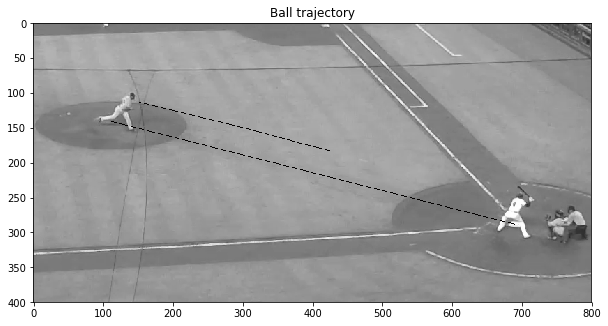

RELEASE FRAME AT  110.0 SPEED in mph 96.745871541

video: 490770-26c36f4b-d646-47c3-b06d-a049a0d3828d.m4v
j 0 3.43210337456 50.6211418283 0.394957983193 0.0730405653031
k 0 3.41494797711 55.5630272753 0.25 0.0831412318884
metric:  0.0171553974429 0.0889419761554 0.394957983193 0.25
trajectory [[633, 239], [682, 254], [735, 269]]
frames from release frame (using distance from center of base projected) 11.9926295085
trajectory [[633, 239], [682, 254], [735, 269]]
frames from release frame (using distance from center of base projected) 11.9926295085


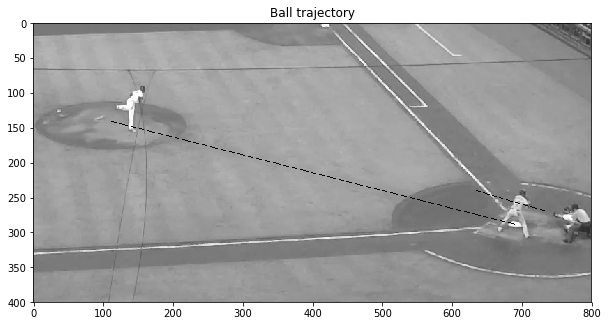

RELEASE FRAME AT  110.0 SPEED in mph 108.74274644

video: 490770-280bedf8-0c8b-42c3-aeb9-1b42ec473aa7.m4v
j 0 3.35423757595 45.0138867462 0.166666666667 0.0652339417523
k 0 3.36755187128 44.6346278129 0.0769230769231 0.0276172858815
metric:  0.0133142953309 0.00849696641023 0.166666666667 0.0769230769231
trajectory [[146, 113], [190, 122], [234, 132]]
frames from release frame (using distance from center of base projected) 2.6265812636
trajectory [[146, 113], [190, 122], [234, 132]]
frames from release frame (using distance from center of base projected) 2.6265812636


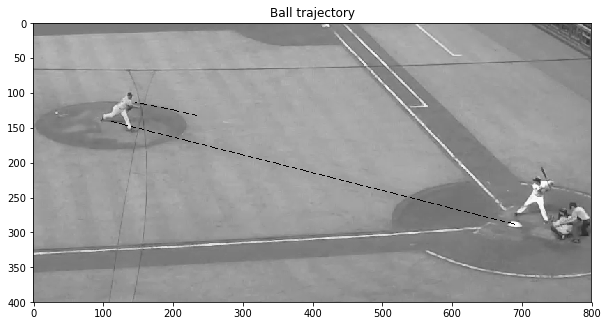

RELEASE FRAME AT  95.0 SPEED in mph 92.0792616419

video: 490770-28b71b3e-cb07-4ad2-9ea2-beb68fa85e62.m4v
j 0 3.38657131672 45.3541618818 0.4 0.114876605417
k 0 3.42140976211 45.2603579305 0.428571428571 0.103792340457
metric:  0.0348384453964 0.00207254108341 0.4 0.428571428571
trajectory [[187, 115], [231, 126], [275, 139]]
frames from release frame (using distance from center of base projected) 3.50004849838
k 0 3.40153279378 48.6338359581 0.0 0.145628380571
metric:  0.0198769683347 0.0693648354302 0.428571428571 0.0
trajectory [[187, 115], [231, 126], [275, 139], [322, 151]]
frames from release frame (using distance from center of base projected) 4.4690205955


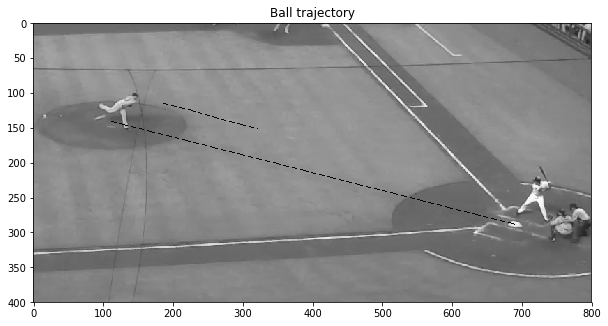

RELEASE FRAME AT  109.0 SPEED in mph 95.2787283733

video: 490770-2e192582-a796-4e57-a1e5-2164414344ec.m4v
j 0 3.39383511148 50.0849278726 0.153846153846 0.0962921881136
k 0 3.39635095603 49.6009072498 0.2 0.068856489301
metric:  0.00251584454608 0.00975830180606 0.153846153846 0.2
trajectory [[433, 174], [482, 186], [530, 199]]
frames from release frame (using distance from center of base projected) 8.41618501166
k 0 3.39635095603 49.6009072498 0.166666666667 0.068856489301
metric:  0.0 0.0 0.2 0.166666666667
k 0 3.41989231259 50.960769225 0.166666666667 0.0517671792791
metric:  0.0235413565692 0.0266844868293 0.166666666667 0.166666666667
k 0 3.40092439799 50.6951674225 0.6 0.0693865011767
metric:  0.0189679146044 0.00523919371256 0.166666666667 0.6
k 0 3.42964810064 56.3205113613 0.553571428571 0.0512371674034
metric:  0.0287237026499 0.099880910219 0.6 0.553571428571
trajectory [[433, 174], [482, 186], [530, 199], [578, 211], [627, 225], [676, 238], [730, 254]]
frames from release 

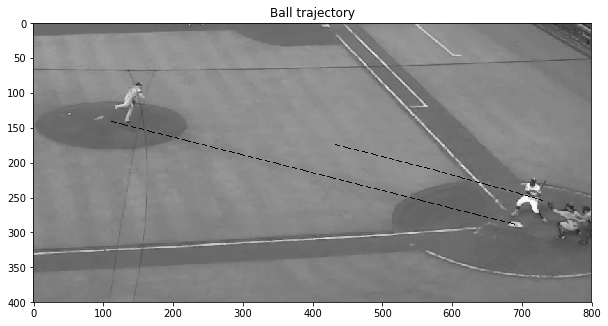

RELEASE FRAME AT  109.0 SPEED in mph 104.874168252

video: 490770-2eed2f10-08e4-4377-afd0-939f1d51dbe3.m4v
j 0 3.40499028614 46.0895866764 0.272727272727 0.0836035527062
k 0 3.39723757887 45.4780166674 0.2 0.0618678458644
metric:  0.00775270726757 0.013447596307 0.272727272727 0.2
trajectory [[506, 187], [551, 199], [595, 211]]
frames from release frame (using distance from center of base projected) 10.5772968604
k 0 3.41839081222 45.7411193567 0.166666666667 0.205834178104
metric:  0.0211532333541 0.00575199498748 0.2 0.166666666667
k 0 0.18440927693 490.822014584 0.3 0.466128993486
metric:  3.23398153529 0.906807115415 0.166666666667 0.3
k 1 3.42414760606 48.4200371747 0.714285714286 0.120768638135
metric:  0.0057567938376 0.0553266369537 0.166666666667 0.714285714286
k 0 3.42705551386 47.9400667501 0.125 0.0533301664402
metric:  0.00290790779716 0.01001188478 0.714285714286 0.125
k 0 0.185495088157 626.243163635 0.333333333333 0.183622326169
metric:  3.2415604257 0.923448159543 0.12

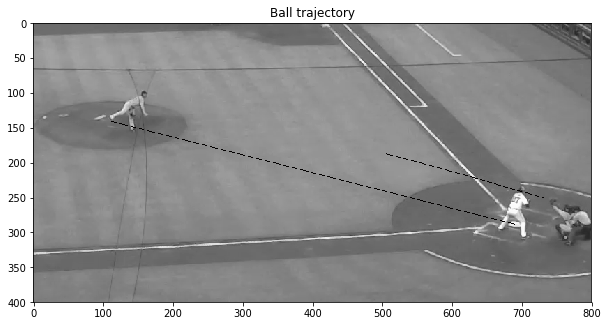

RELEASE FRAME AT  106.0 SPEED in mph 95.5928579383

video: 490770-3071770f-8a6b-4585-a2f0-1ac435f28ffb.m4v
j 0 3.33898821344 38.2426463519 0.107692307692 0.0964737751826
k 0 3.38657131672 37.1079506306 0.333333333333 0.141897054604
metric:  0.047583103277 0.0305782373347 0.107692307692 0.333333333333
trajectory [[156, 101], [194, 109], [230, 118]]
frames from release frame (using distance from center of base projected) 2.91990031712
k 0 3.39891636856 39.2937654088 0.5 0.141897054604
metric:  0.0123450518442 0.0556275214523 0.333333333333 0.5
k 0 3.41118173151 39.4239774756 0.166666666667 0.068856489301
metric:  0.0122653629498 0.00330286478442 0.5 0.166666666667
k 0 3.40219504534 38.8104367407 0.0833333333333 0.0276172858815
metric:  0.00898668617359 0.0158086532005 0.166666666667 0.0833333333333
k 0 3.40784470274 39.9061398785 0.107692307692 0.0964737751826
metric:  0.00564965740358 0.0274570063944 0.0833333333333 0.107692307692
k 0 3.44447752196 41.9076365356 0.166666666667 0.0688564

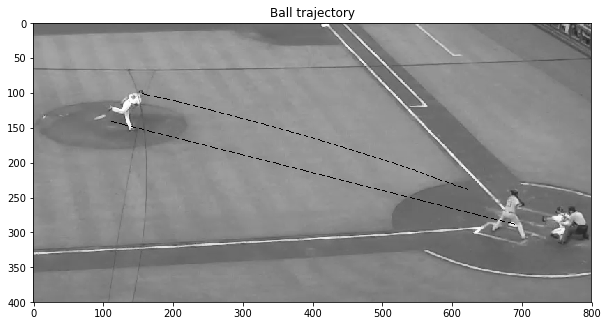

RELEASE FRAME AT  101.0 SPEED in mph 83.0222344289

video: 490770-325a94ab-c6cf-41b4-8894-fcdf44c2870a.m4v
j 0 3.41253950393 46.7038542307 0.294871794872 0.00578028244366
k 0 3.43613903659 46.5026880943 0.309090909091 0.0370201158739
metric:  0.023599532661 0.00432590339551 0.294871794872 0.309090909091
trajectory [[172, 109], [217, 121], [262, 135]]
frames from release frame (using distance from center of base projected) 3.11868221327
k 0 3.41420247357 48.2830197896 0.0833333333333 0.0312398334303
metric:  0.0219365630188 0.0368728323743 0.309090909091 0.0833333333333
k 0 3.41989231259 47.3207142803 0.0769230769231 0.0312398334303
metric:  0.00568983902449 0.0203358196063 0.0833333333333 0.0769230769231
k 0 3.42261339431 50.4801941359 0.0833333333333 0.0356991126793
metric:  0.00272108171947 0.0625885044556 0.0769230769231 0.0833333333333
k 0 3.45052339751 49.3355855342 0.181818181818 0.0669389461096
metric:  0.0279100031992 0.0232004665466 0.0833333333333 0.181818181818
k 0 3.4321033

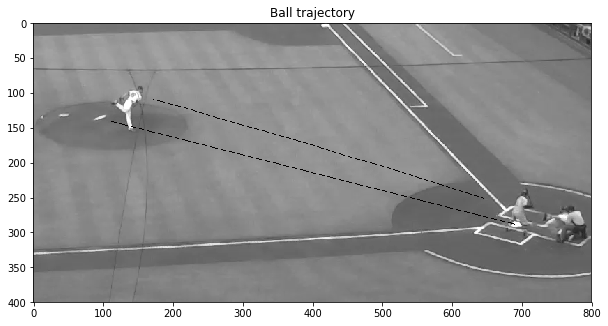

RELEASE FRAME AT  91.0 SPEED in mph 101.226269169

video: 490770-34172a92-9da2-4adc-b713-7bb19224b2c4.m4v
j 0 3.33242375631 44.8135024295 0.166666666667 0.0587558227157
k 0 3.37082458687 46.2087654022 0.306666666667 0.0232516228105
metric:  0.0384008305557 0.0301947684728 0.166666666667 0.306666666667
trajectory [[183, 120], [227, 128], [272, 139]]
frames from release frame (using distance from center of base projected) 3.4451654939
k 0 3.35191852725 45.5027471698 0.346153846154 0.0445250088345
metric:  0.0189060596119 0.0155159474174 0.306666666667 0.346153846154
k 0 3.37149708172 48.2700735446 0.0 0.0
metric:  0.0195785544668 0.0573300633615 0.346153846154 0.0
k 0 3.39414692937 48.0234317807 0.0714285714286 0.0212733860241
metric:  0.0226498476462 0.00513586294641 0.0 0.0714285714286
k 0 3.4069247398 47.6681235209 0.2 0.0587558227157
metric:  0.0127778104309 0.00745379162514 0.0714285714286 0.2
k 0 3.40873517446 49.246827309 0.0666666666667 0.0217357068418
metric:  0.00181043465671 0

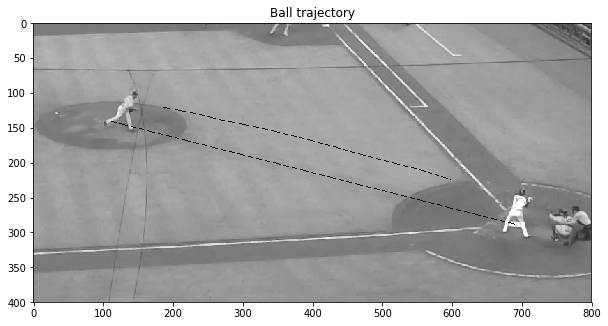

RELEASE FRAME AT  107.0 SPEED in mph 97.5169833439

video: 490770-377b386d-8176-4cdb-98ce-2646ffe829a1.m4v
j 0 3.37804879579 42.687820277 0.0714285714286 0.0275159892855
k 0 3.38940417033 42.807709586 0.230769230769 0.0376166558708
metric:  0.0113553745388 0.00280064759793 0.0714285714286 0.230769230769
trajectory [[175, 118], [216, 128], [258, 138]]
frames from release frame (using distance from center of base projected) 3.34797593141
k 0 3.38657131672 45.3541618818 0.0 0.0
metric:  0.00283285361184 0.0561459453803 0.230769230769 0.0
k 0 3.41839081222 45.7411193567 0.2 0.0730405653031
metric:  0.0318194955051 0.00845972902076 0.0 0.2
k 0 3.39723757887 45.4780166674 0.25 0.0730405653031
metric:  0.0211532333541 0.00578527184211 0.2 0.25
k 0 3.43199459614 45.4009911786 0.516666666667 0.0991502492198
metric:  0.0347570172705 0.00169655962986 0.25 0.516666666667
k 0 3.43304944807 46.9813792901 0.142857142857 0.061533593349
metric:  0.00105485192943 0.0336386060897 0.516666666667 0.1428571

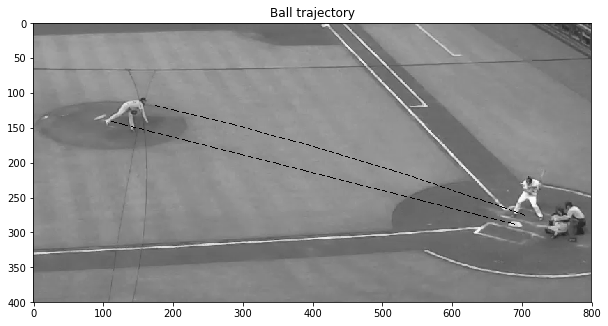

RELEASE FRAME AT  91.0 SPEED in mph 94.2844188777

video: 490770-39792d6d-ecca-4814-9300-b0b8a388acc7.m4v
j 0 3.36403991902 43.0610032396 0.25 0.0730405653031
k 0 3.3810919195 44.2634160453 0.4 0.0101006665853
metric:  0.0170520004842 0.027164934683 0.25 0.4
trajectory [[172, 114], [214, 123], [257, 134]]
frames from release frame (using distance from center of base projected) 3.22847849337
k 0 3.35660753534 44.5252737218 0.107142857143 0.0831412318884
metric:  0.0244843841627 0.00588110200321 0.4 0.107142857143
k 0 3.37584786718 45.2354949127 0.306666666667 0.0232516228105
metric:  0.0192403318467 0.0157005288064 0.107142857143 0.306666666667
k 0 3.38657131672 45.3541618818 0.730769230769 0.0820074455262
metric:  0.0107234495326 0.00261645159201 0.306666666667 0.730769230769
trajectory [[172, 114], [214, 123], [257, 134], [300, 143], [344, 154], [388, 165]]
frames from release frame (using distance from center of base projected) 6.20837335046


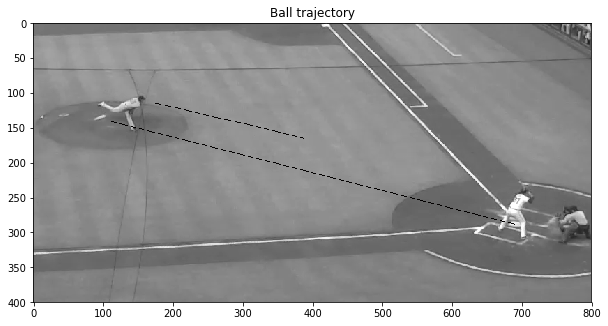

RELEASE FRAME AT  109.0 SPEED in mph 90.8092534396

video: 490770-399d82f0-09f9-4465-9742-036a23d4007c.m4v
j 0 3.39448671869 45.9619407771 0.142857142857 0.0824215486734
k 0 3.40970343666 47.1858029496 0.4 0.267472056679
metric:  0.0152167179742 0.0259370848006 0.142857142857 0.4
trajectory [[168, 107], [212, 119], [258, 131]]
frames from release frame (using distance from center of base projected) 3.03149284861
k 0 3.40219504534 46.5725240888 0.166666666667 0.185050508006
metric:  0.00750839132249 0.0131682547346 0.4 0.166666666667
k 0 3.40873517446 49.246827309 0.0714285714286 0.0241498933975
metric:  0.00654012911835 0.0543040712738 0.166666666667 0.0714285714286
k 0 3.42821389582 49.5201978994 0.0769230769231 0.0276172858815
metric:  0.0194787213598 0.00552038566209 0.0714285714286 0.0769230769231
trajectory [[168, 107], [212, 119], [258, 131], [303, 143], [350, 156], [398, 170]]
frames from release frame (using distance from center of base projected) 6.00719573392


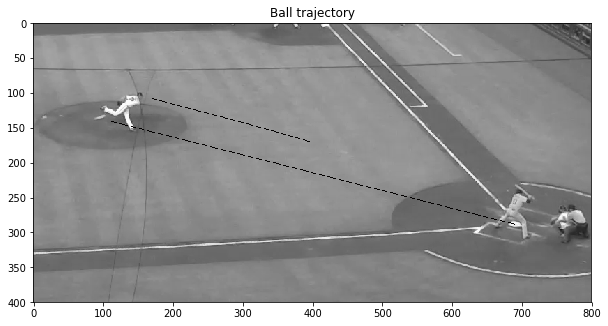

RELEASE FRAME AT  88.0 SPEED in mph 97.5615038812

video: 490770-3b5a5d69-0b56-4184-88ce-06ce8d6ccc9e.m4v
j 0 0.398184569792 430.694787524 0.619047619048 1.11472433045
k 0 3.55670396641 424.010613075 3.125 0.826470941988
metric:  3.15851939661 0.0157641677891 0.619047619048 3.125
j 0 3.55670396641 424.010613075 3.125 0.826470941988
j 0 3.34791654762 43.931765273 0.153846153846 0.0378965398388
k 0 3.38954749841 40.7461654638 0.4 0.144289394538
metric:  0.041630950786 0.0781815852599 0.153846153846 0.4
trajectory [[180, 114], [223, 123], [263, 133]]
frames from release frame (using distance from center of base projected) 3.4418998732
k 0 3.39230191301 42.3231615076 0.047619047619 0.10200691791
metric:  0.00275441460572 0.0372608280593 0.4 0.047619047619
k 0 3.37844141454 44.7493016705 0.35 0.00438593678879
metric:  0.0138604984745 0.0542162686867 0.047619047619 0.35
k 0 3.37844141454 44.7493016705 0.346153846154 0.0445250088345
metric:  0.0 0.0 0.35 0.346153846154
trajectory [[180, 114],

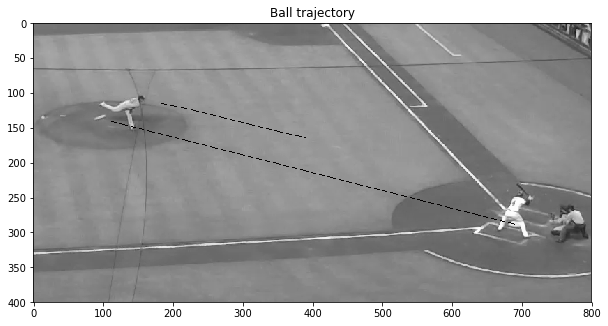

RELEASE FRAME AT  112.0 SPEED in mph 88.7201174135

video: 490770-3c1a0b14-2651-42e0-8049-b5a7538f6fe7.m4v
j 0 3.43002221211 47.4605099003 0.230769230769 0.0376166558708
k 0 3.42449350712 44.7800178651 0.4 0.0101006665853
metric:  0.00552870499031 0.0598591104474 0.230769230769 0.4
trajectory [[336, 141], [382, 154], [425, 167]]
frames from release frame (using distance from center of base projected) 6.72867343386
k 0 3.45680735334 48.3838816136 0.333333333333 0.114254327961
metric:  0.0323138462226 0.0744848000679 0.4 0.333333333333
k 0 3.44695123368 48.2312139594 0.125 0.0554985052457
metric:  0.00985611966207 0.00316532887423 0.333333333333 0.125
k 0 3.46014833068 49.4898979591 0.30612244898 0.0
metric:  0.0131970969994 0.0254331500278 0.125 0.30612244898
k 0 3.47632949091 48.7031826475 0.0 0.0
metric:  0.0161811602287 0.0161532628623 0.30612244898 0.0
k 0 -0.0300338846648 116.552563249 0.3671875 0.321750554397
metric:  3.50636337557 0.58213546498 0.0 0.3671875
k 1 3.47268873029 50.

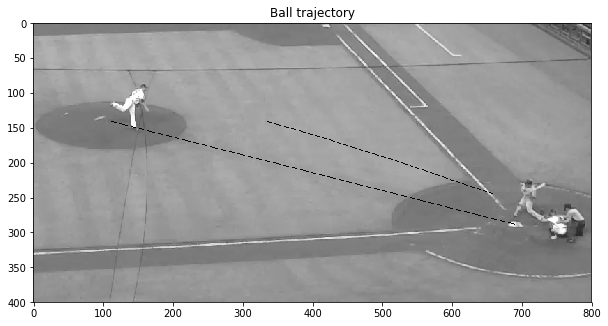

RELEASE FRAME AT  112.0 SPEED in mph 98.8069303124

video: 490770-3c687faa-deb4-4232-ad2a-036ecff2c739.m4v
j 0 2.71562917099 249.274948601 0.114285714286 0.527662586835
k 0 3.42307195212 43.2001157406 0.0769230769231 0.0275159892855
metric:  0.707442781128 4.77023798033 0.114285714286 0.0769230769231
j 0 3.39723757887 45.4780166674 0.166666666667 0.0587558227157
k 0 3.40970343666 47.1858029496 0.0816326530612 0.0831412318884
metric:  0.0124658577919 0.0361927990087 0.166666666667 0.0816326530612
trajectory [[289, 148], [333, 159], [378, 172]]
frames from release frame (using distance from center of base projected) 5.80544864993
k 0 3.45658655405 46.8027776953 0.222222222222 0.0374824366917
metric:  0.046883117391 0.00818381457535 0.0816326530612 0.222222222222
k 0 3.42140976211 45.2603579305 0.0571428571429 0.156322781259
metric:  0.0351767919376 0.0340788238392 0.222222222222 0.0571428571429
k 0 3.43787101148 49.6638701674 0.0909090909091 0.10455560198
metric:  0.0164612493627 0.08866

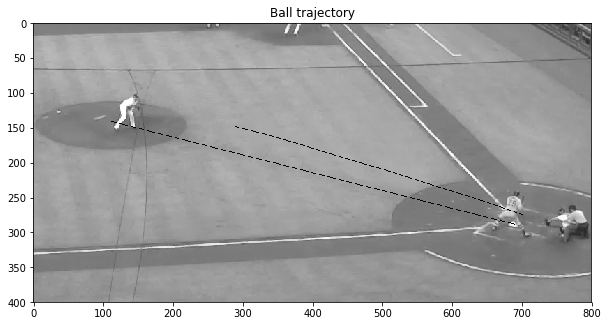

RELEASE FRAME AT  96.0 SPEED in mph 97.9444672443

video: 490770-3cbe6f30-6f59-4b5c-a6e3-ffb5e8b0e30d.m4v
j 0 3.35191852725 45.5027471698 0.8 0.0831412318884
k 0 3.38133576246 46.3249392876 0.0 0.0
metric:  0.0294172352054 0.0177483690304 0.8 0.0
trajectory [[155, 103], [199, 113], [244, 124]]
frames from release frame (using distance from center of base projected) 2.75354227827
k 0 3.39945720139 47.0558179187 0.466666666667 0.0587558227157
metric:  0.0181214389305 0.0155321629386 0.0 0.466666666667
k 0 3.36138772511 48.1585921721 0.458333333333 0.0212733860241
metric:  0.038069476277 0.0228988058756 0.466666666667 0.458333333333
k 0 3.38155882737 48.3864650496 0.2 0.0618678458644
metric:  0.0201711022546 0.00470943428688 0.458333333333 0.2
k 0 0.182701540341 266.942877785 0.392857142857 0.20065287732
metric:  3.19885728703 0.818738505214 0.2 0.392857142857
k 1 3.40873517446 49.246827309 0.0714285714286 0.0275159892855
metric:  0.027176347087 0.0174704098995 0.2 0.0714285714286
k 0 0.2

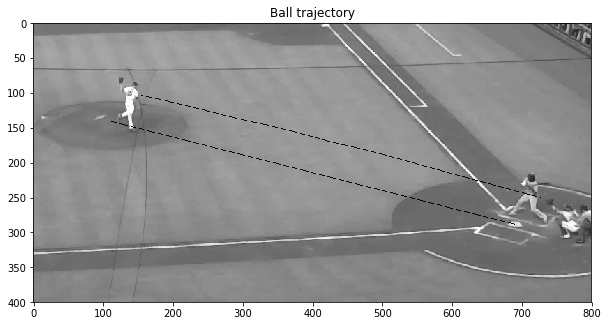

RELEASE FRAME AT  111.0 SPEED in mph 100.853767636

video: 490770-3d69a818-568e-4eef-9d63-24687477e7ee.m4v
j 0 3.43304944807 41.7612260356 0.0 0.0
k 0 3.41826099267 42.10106887 0.1 0.10455560198
metric:  0.014788455396 0.00807207141103 0.0 0.1
trajectory [[410, 172], [450, 184], [490, 196]]
frames from release frame (using distance from center of base projected) 9.15011399579
trajectory [[410, 172], [450, 184], [490, 196]]
frames from release frame (using distance from center of base projected) 9.15011399579


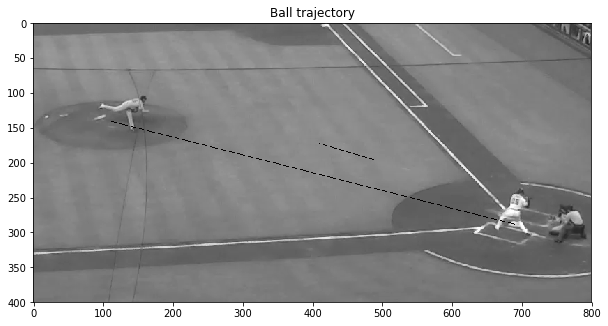

RELEASE FRAME AT  100.0 SPEED in mph 85.4206668395

video: 490770-3ee905e0-03dd-4774-b796-9bdc46ed124b.m4v
j 0 3.27663528394 185.690602886 0.4 0.574304830175
k 0 3.41839081222 45.7411193567 0.25 0.0730405653031
metric:  0.141755528285 3.05959901063 0.4 0.25
j 0 3.45720831563 51.5460958754 0.166666666667 0.0587558227157
k 0 3.43495966542 50.1422975142 0.166666666667 0.0618678458644
metric:  0.0222486502091 0.0279962911725 0.166666666667 0.166666666667
trajectory [[482, 195], [531, 211], [579, 225]]
frames from release frame (using distance from center of base projected) 9.36707396484
k 0 3.44795980621 51.3930929211 0.371428571429 0.0157467298499
metric:  0.0130001407863 0.0243378114813 0.166666666667 0.371428571429
k 0 3.46660052546 48.5412195974 0.375 0.0360204494292
metric:  0.0186407192506 0.0587515795321 0.371428571429 0.375
trajectory [[482, 195], [531, 211], [579, 225], [628, 241], [674, 256]]
frames from release frame (using distance from center of base projected) 11.4261681465


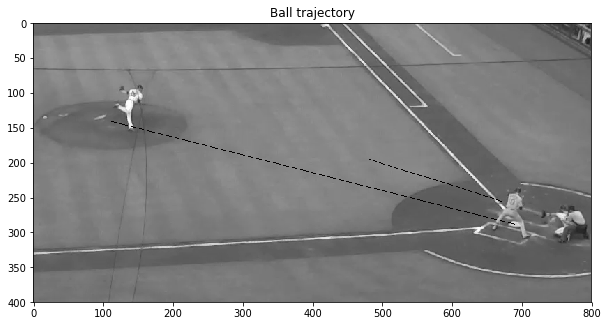

RELEASE FRAME AT  107.0 SPEED in mph 103.027510042

video: 490770-410fe0f1-89f6-41fb-bd18-e1653d256760.m4v
j 0 3.37844141454 44.7493016705 0.384615384615 0.215641709914
k 0 3.35268598681 42.9534631898 0.285714285714 0.102206718107
metric:  0.0257554277242 0.0418089333743 0.384615384615 0.285714285714
trajectory [[157, 103], [201, 114], [243, 123]]
frames from release frame (using distance from center of base projected) 2.82422083886
k 0 3.39157127505 48.5077313425 0.2 0.0587558227157
metric:  0.0388852882381 0.114502740058 0.285714285714 0.2
k 0 3.37388164256 47.7833653063 0.25 0.0611481626493
metric:  0.0176896324898 0.0151593767318 0.2 0.25
trajectory [[157, 103], [201, 114], [243, 123], [290, 135], [336, 146]]
frames from release frame (using distance from center of base projected) 4.79065861935


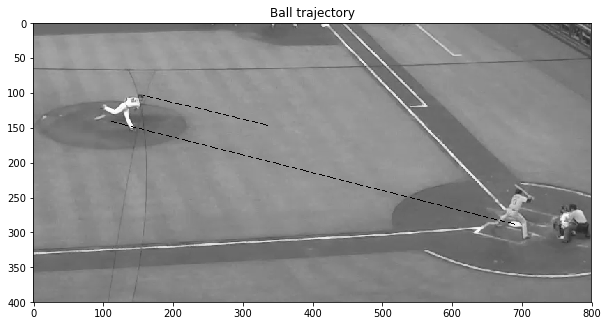

RELEASE FRAME AT  108.0 SPEED in mph 94.1483054041

video: 490770-4313b6eb-6fd9-40a8-92c7-70e8dffe1b5a.m4v
j 0 3.36839150164 40.0249921924 0.416666666667 0.309702944542
k 0 3.39774403616 43.4165866922 0.285714285714 0.185347949996
metric:  0.0293525345117 0.078117483621 0.416666666667 0.285714285714
trajectory [[157, 105], [196, 114], [238, 125]]
frames from release frame (using distance from center of base projected) 2.88413935666
k 0 3.38657131672 41.2310562562 0.0 0.0
metric:  0.0111727194387 0.0530068990333 0.285714285714 0.0
k 0 3.40291863421 44.5112345369 0.0277777777778 0.12062366858
metric:  0.0163473174956 0.0736932667643 0.0 0.0277777777778
k 0 3.41505364068 42.5822733071 0.314285714286 0.0212733860241
metric:  0.0121350064677 0.0452996301045 0.0277777777778 0.314285714286
k 0 3.42140976211 45.2603579305 0.895833333333 0.172190814523
metric:  0.006356121433 0.0591706461436 0.314285714286 0.895833333333
k 0 3.45296295799 45.697374104 0.0769230769231 0.0302937599188
metric:  0.

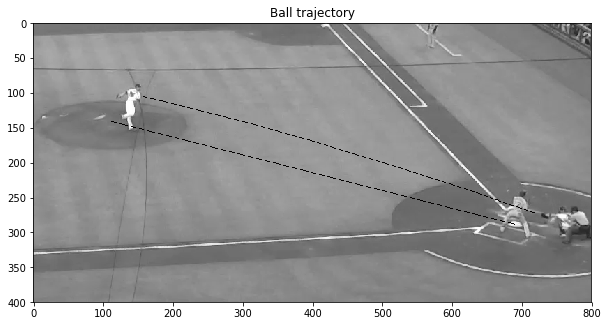

RELEASE FRAME AT  99.0 SPEED in mph 92.4501510456

video: 490770-43bb2a80-6528-43f7-bc08-68bececf5723.m4v
j 0 3.46723423893 40.6355755466 0.388888888889 0.114876605417
k 0 3.45954094494 41.5842518269 0.636363636364 0.114876605417
metric:  0.007693293992 0.0228133545424 0.388888888889 0.636363636364
trajectory [[404, 157], [442, 170], [482, 183]]
frames from release frame (using distance from center of base projected) 9.03160443131
k 0 3.47826747298 42.3792402008 0.0 0.0
metric:  0.0187265280354 0.0187589104997 0.636363636364 0.0
k 0 3.5045184246 42.2522188766 0.444444444444 0.0880073735277
metric:  0.026250951625 0.00300626399193 0.0 0.444444444444
k 0 0.206683218484 411.763585083 0.00961538461538 0.582514184453
metric:  3.29783520612 0.897387189136 0.444444444444 0.00961538461538
k 1 3.5264563016 42.6174846747 0.0769230769231 0.032508868282
metric:  0.0219378769999 0.00857079672491 0.444444444444 0.0769230769231
k 0 0.235544980721 449.923604626 0.0357142857143 0.408149103755
metric:  

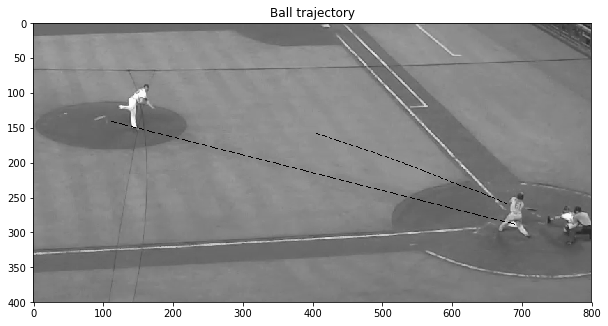

RELEASE FRAME AT  4.0 SPEED in mph 86.0162213781

video: 490770-4529d8f9-d4e1-4114-a5d4-e9700c535c3f.m4v
j 0 3.37584786718 45.2354949127 0.2 0.0647242814156
k 0 3.3810919195 44.2634160453 1.0 0.134110782592
metric:  0.00524405231591 0.0219612256413 0.2 1.0
trajectory [[185, 111], [229, 122], [272, 132]]
frames from release frame (using distance from center of base projected) 3.46368578129
k 0 3.39677504421 47.539457296 0.464285714286 0.0176193218976
metric:  0.0156831247107 0.0689120456364 1.0 0.464285714286
k 0 3.42140976211 45.2603579305 0.3 0.0376166558708
metric:  0.0246347179024 0.0503553102471 0.464285714286 0.3
trajectory [[185, 111], [229, 122], [272, 132], [318, 144], [361, 157]]
frames from release frame (using distance from center of base projected) 5.43987621431


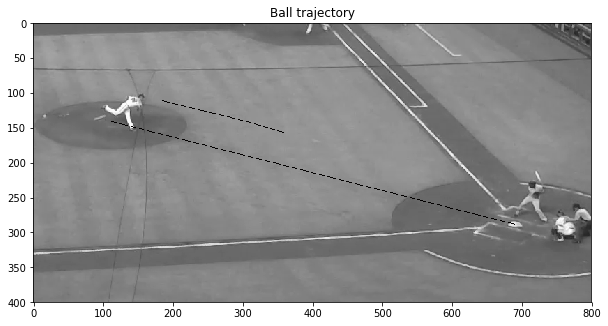

RELEASE FRAME AT  111.0 SPEED in mph 93.0493665276

video: 490770-47bd053e-81ea-4a4c-95b2-58298d6d088f.m4v
j 0 3.37149708172 48.2700735446 0.615384615385 0.0694533259953
k 0 3.41850149291 49.3811705005 0.0857142857143 0.077856489543
metric:  0.0470044111859 0.0225004175611 0.615384615385 0.0857142857143
trajectory [[321, 156], [368, 167], [416, 181]]
frames from release frame (using distance from center of base projected) 6.24147076522
k 0 1.24643934911 181.989697511 0.3125 0.712678934844
metric:  2.1720621438 0.728659527567 0.0857142857143 0.3125
k 1 3.44083896919 49.1858719553 0.0208333333333 0.10487693873
metric:  0.0223374762847 0.00397062281249 0.0857142857143 0.0208333333333
k 0 3.39383511148 50.0849278726 0.0816326530612 0.0831412318884
metric:  0.0470038577127 0.0179506281727 0.0208333333333 0.0816326530612
k 0 3.43495966542 50.1422975142 0.277777777778 0.0133325432941
metric:  0.0411245539399 0.0011441366761 0.0816326530612 0.277777777778
k 0 3.4253867628 50.0 0.830769230769 0

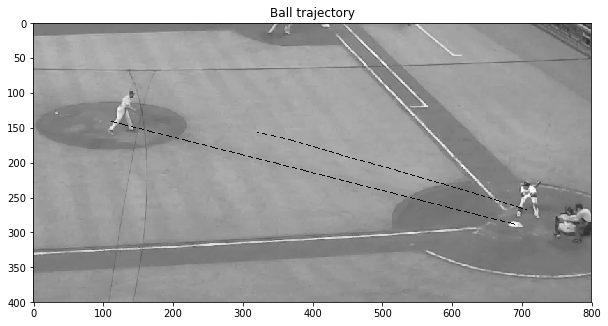

RELEASE FRAME AT  90.0 SPEED in mph 102.716452011

video: 490770-4cd75285-dba9-4f93-9120-47a118e0d2e9.m4v
j 0 3.3920357432 44.3846820423 0.428571428571 0.0831412318884
k 0 3.40153279378 48.6338359581 0.458333333333 0.0212733860241
metric:  0.00949705057718 0.0873703221646 0.428571428571 0.458333333333
trajectory [[171, 107], [214, 118], [261, 130]]
frames from release frame (using distance from center of base projected) 3.09689940316
k 0 3.40499028614 46.0895866764 0.528571428571 0.0767718912698
metric:  0.00345749235697 0.0552022585836 0.458333333333 0.528571428571
k 0 3.40608103614 49.7292670366 0.969696969697 0.100921784667
metric:  0.00109075000373 0.0731899056055 0.528571428571 0.969696969697
k 0 3.41576010471 49.8623104158 0.2 0.0652339417523
metric:  0.00967906857043 0.00266821529226 0.969696969697 0.2
k 0 3.42414760606 48.4200371747 0.025641025641 0.129522907196
metric:  0.00838750134993 0.0297867024735 0.2 0.025641025641
k 0 3.43865686593 51.2445119013 0.225 0.160762740626
met

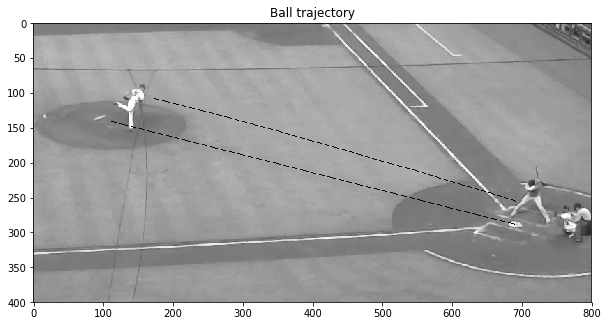

RELEASE FRAME AT  106.0 SPEED in mph 100.730668234

video: 490770-4d96ea99-26f7-4e51-b6fa-0d56f3d50450.m4v
j 0 2.11121582707 20.408331632 2.0 0.393176264422
k 0 3.14717918765 89.5013966371 0.409090909091 0.309539492435
metric:  1.03596336058 0.771977506511 2.0 0.409090909091
j 0 3.41989231259 43.6806593357 0.0 0.0
k 0 3.43843732697 44.4437847173 0.0769230769231 0.0276172858815
metric:  0.0185450143713 0.0171705759646 0.0 0.0769230769231
trajectory [[369, 155], [411, 167], [454, 180]]
frames from release frame (using distance from center of base projected) 7.74851397132
k 0 3.42764409531 44.3001128667 0.3 0.0376166558708
metric:  0.0107932316591 0.00324314863677 0.0769230769231 0.3
k 0 3.43199459614 45.4009911786 0.384615384615 0.110657221174
metric:  0.00435050083112 0.0242478915846 0.3 0.384615384615
k 0 3.46334320799 45.8530260724 1.1875 0.114876605417
metric:  0.0313486118482 0.00985834376819 0.384615384615 1.1875
k 0 3.46682751444 45.3789598823 0.00952380952381 0.115027822715
metri

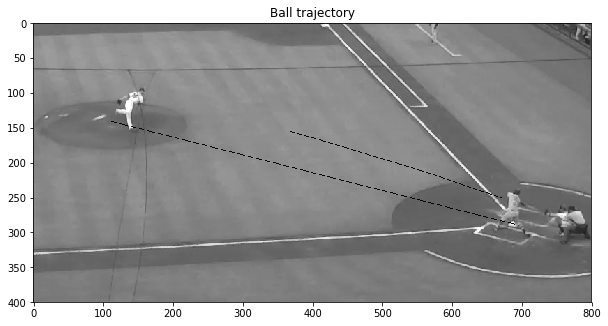

RELEASE FRAME AT  88.0 SPEED in mph 92.5264098458

video: 490770-5272649e-b530-46f7-bcdd-0813ae0c04d7.m4v
j 0 3.38082425355 42.201895692 0.133333333333 0.057314209106
k 0 3.39485841982 43.9004555785 0.120879120879 0.191056500545
metric:  0.0140341662671 0.0386911676451 0.133333333333 0.120879120879
trajectory [[204, 124], [245, 134], [288, 145]]
frames from release frame (using distance from center of base projected) 4.0124475052
k 0 3.10015297598 205.176143837 0.25 0.727491958149
metric:  0.294705443841 0.786035282868 0.120879120879 0.25
k 1 3.39230191301 42.3231615076 0.1 0.160762740626
metric:  0.00255650680934 0.0372678697597 0.120879120879 0.1
k 0 3.41678190272 44.1616349335 0.25 0.0831412318884
metric:  0.0244799897078 0.0416305562204 0.1 0.25
k 0 3.43199459614 45.4009911786 0.0666666666667 0.0243854091727
metric:  0.0152126934193 0.0272979997337 0.25 0.0666666666667
k 0 3.41543468982 46.2222889957 0.107142857143 0.0831412318884
metric:  0.0165599063213 0.0177684367199 0.06666666

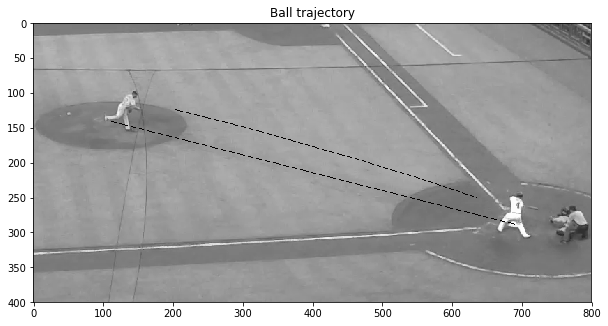

RELEASE FRAME AT  91.0 SPEED in mph 92.0820620817

video: 490770-5283a339-890f-4f3a-ae38-7f2e3e852111.m4v
j 0 3.41826099267 42.10106887 0.236111111111 0.0370201158739
k 0 3.47064234843 43.3243580449 0.0 0.0
metric:  0.0523813557584 0.0282355984031 0.236111111111 0.0
trajectory [[460, 179], [500, 190], [541, 204]]
frames from release frame (using distance from center of base projected) 10.2249443029
k 0 3.44095888765 42.385138905 0.309090909091 0.0370201158739
metric:  0.029683460783 0.0221591615384 0.0 0.309090909091
k 0 0.202065305759 440.971937883 0.388888888889 0.75837771421
metric:  3.23889358189 0.903882457672 0.309090909091 0.388888888889
k 1 3.48461659401 44.598206242 0.555555555556 0.0554985052457
metric:  0.0436577063634 0.0496223396274 0.309090909091 0.555555555556
k 0 0.220808100458 481.6951837 0.607142857143 0.702879208964
metric:  3.26380849355 0.907414049899 0.555555555556 0.607142857143
k 1 0.191619728815 509.32209848 0.428571428571 0.266252049151
metric:  3.2929968652 0

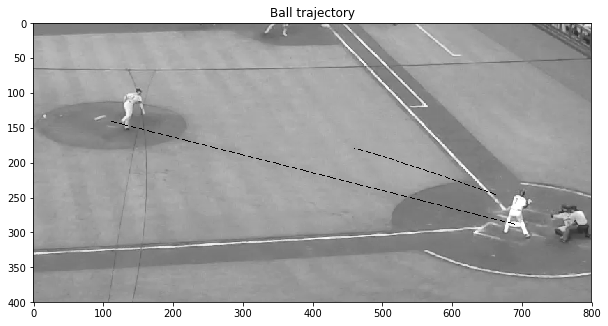

RELEASE FRAME AT  91.0 SPEED in mph 88.2586751566

video: 490770-52aa7464-7a07-4ab4-993e-12f1db35caa5.m4v
j 0 3.43304944807 46.9813792901 0.4 0.0101006665853
k 0 3.43109632555 49.040799341 0.142857142857 0.0587558227157
metric:  0.00195312251648 0.0419940147497 0.4 0.142857142857
trajectory [[202, 115], [247, 129], [294, 143]]
frames from release frame (using distance from center of base projected) 3.72535714563
k 0 3.45009894932 47.7545809321 0.0972222222222 0.0964737751826
metric:  0.0190026237705 0.0269339272538 0.142857142857 0.0972222222222
k 0 3.44447752196 50.2891638427 0.4 0.126767535101
metric:  0.00562142735694 0.050400180018 0.0972222222222 0.4
trajectory [[202, 115], [247, 129], [294, 143], [339, 157], [387, 172]]
frames from release frame (using distance from center of base projected) 5.71423089453


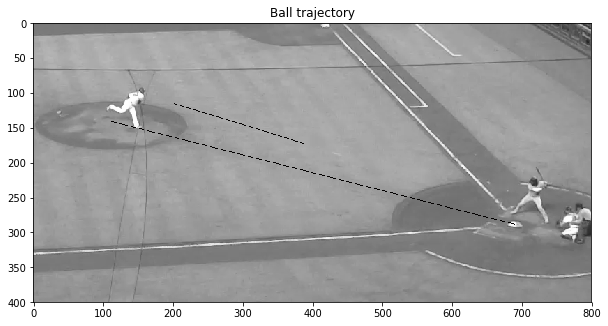

RELEASE FRAME AT  94.0 SPEED in mph 98.9922706899

video: 490770-5491257a-021c-4083-b23c-c1bdd9f8854c.m4v
j 0 3.3920357432 44.3846820423 0.166666666667 0.0587558227157
k 0 3.37082458687 46.2087654022 0.285714285714 0.0101006665853
metric:  0.0212111563344 0.0394748343529 0.166666666667 0.285714285714
trajectory [[160, 112], [203, 123], [248, 133]]
frames from release frame (using distance from center of base projected) 2.91784907665
trajectory [[160, 112], [203, 123], [248, 133]]
frames from release frame (using distance from center of base projected) 2.91784907665


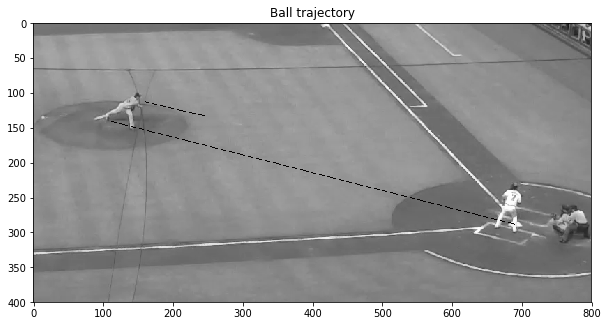

RELEASE FRAME AT  106.0 SPEED in mph 92.538797932

video: 490770-56eaaac2-6e0f-4e83-9e6b-75880ca36900.m4v
j 0 3.46334320799 53.7587202229 0.166666666667 0.0767718912698
k 0 3.44747152499 49.8121471129 0.7 0.201126885817
metric:  0.0158716829918 0.0792291306172 0.166666666667 0.7
trajectory [[522, 211], [573, 228], [620, 243]]
frames from release frame (using distance from center of base projected) 10.0850802378
trajectory [[522, 211], [573, 228], [620, 243]]
frames from release frame (using distance from center of base projected) 10.0850802378


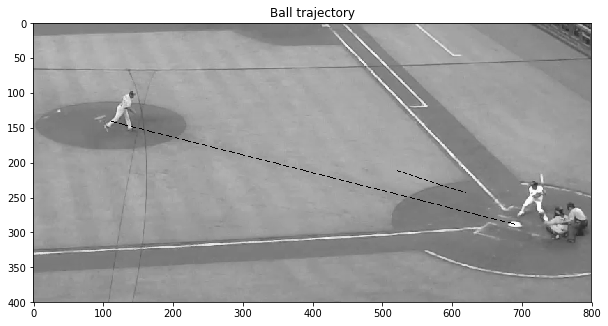

RELEASE FRAME AT  103.0 SPEED in mph 105.437330044

video: 490770-5a772e69-62b1-40fc-a586-4b830d72d17a.m4v
j 0 3.35453100317 37.8549864615 0.153846153846 0.0594536593087
k 0 3.33627819297 36.1835598028 0.0909090909091 0.0318363734271
metric:  0.0182528101954 0.04619298565 0.153846153846 0.0909090909091
trajectory [[157, 100], [194, 108], [230, 115]]
frames from release frame (using distance from center of base projected) 2.95669159658
k 0 3.36026159946 36.8781778292 0.0 0.0
metric:  0.02398340649 0.0188354758098 0.0909090909091 0.0
k 0 3.03142110503 113.689269502 0.4 0.77111342081
metric:  0.328840494429 0.675623055803 0.0 0.4
k 1 3.38657131672 39.1695034434 0.2 0.068856489301
metric:  0.0263097172529 0.0584976936843 0.0 0.2
k 0 3.37713763431 38.5648803965 0.388888888889 0.114876605417
metric:  0.009433682406 0.0156780739523 0.2 0.388888888889
k 0 3.40900345077 37.8450789403 0.0909090909091 0.0270204491873
metric:  0.031865816463 0.019019684365 0.388888888889 0.0909090909091
k 0 3.3895

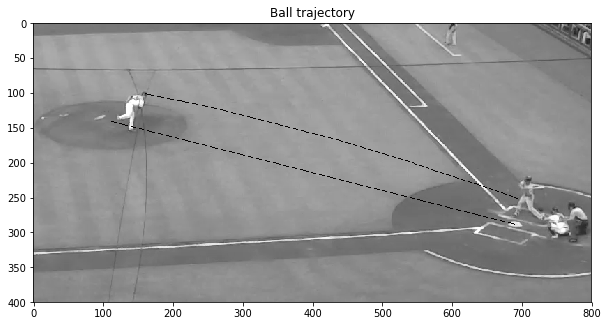

RELEASE FRAME AT  98.0 SPEED in mph 81.5843938262

video: 490770-5b5d1385-ef92-42b2-93e2-8e51ff28d6e2.m4v
j 0 0.892133836047 19.9123077517 0.0833333333333 0.411746210543
k 0 0.422005029902 26.856098004 0.025641025641 0.242333166653
metric:  0.470128806144 0.258555440601 0.0833333333333 0.025641025641
k 1 2.39783706929 16.9852877515 1.33333333333 0.315970271953
metric:  1.50570323324 0.17232678322 0.0833333333333 1.33333333333
j 1 0.165148677415 15.2069063257 0.166666666667 0.186222840411
k 0 0.828849058789 32.5576411922 0.333333333333 0.355635884301
metric:  0.663700381374 0.532923585097 0.166666666667 0.333333333333
k 1 0.148889947609 10.1118742081 2.03333333333 0.281998779001
metric:  0.0162587298051 0.503866248019 0.166666666667 2.03333333333
j 0 0.422005029902 26.856098004 0.025641025641 0.242333166653
k 0 0.340381938642 25.4607541129 0.125 0.058074159563
metric:  0.0816230912603 0.0548037141733 0.025641025641 0.125
trajectory [[753, 235], [729, 224], [705, 215]]
frames from releas

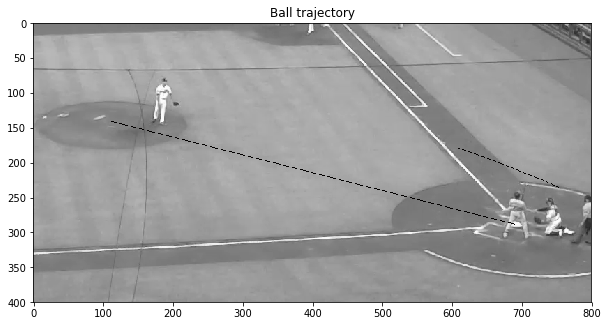

RELEASE FRAME AT  141.0 SPEED in mph 52.3801164626

video: 490770-5d9b0253-1672-4840-a34c-8b6c1d08a688.m4v
j 0 2.67794504459 10.0623058987 0.454545454545 0.165148677415
j 0 0.643501108793 20.0 0.0 0.0
k 0 0.528074448426 20.8386659842 0.166666666667 0.0753288908283
metric:  0.115426660367 0.0402456656684 0.0 0.166666666667
trajectory [[740, 225], [724, 213], [706, 202]]
frames from release frame (using distance from center of base projected) 32.7315000321
k 0 0.528074448426 20.8386659842 0.142857142857 0.0753288908283
metric:  0.0 0.0 0.166666666667 0.142857142857
k 0 0.572966142889 18.4458667457 0.125 0.0554985052457
metric:  0.0448916944623 0.129720076127 0.142857142857 0.125
k 0 0.553294325322 19.9812412027 0.5 0.19739555985
metric:  0.0196718175664 0.0768407948944 0.125 0.5
trajectory [[740, 225], [724, 213], [706, 202], [688, 192], [672, 182], [655, 171]]
frames from release frame (using distance from center of base projected) 36.3213751741


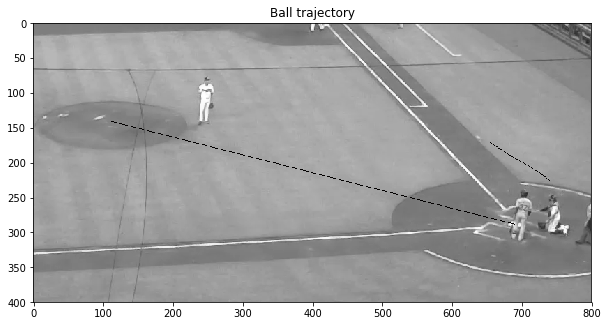

RELEASE FRAME AT  180.0 SPEED in mph 41.2374581617

video: 490770-601c4af6-9d68-45d0-bc11-a9e1ca093bf4.m4v
j 0 3.32694060359 40.6970514902 0.285714285714 0.0101006665853
k 0 3.36561630063 40.5123437979 0.0833333333333 0.0318363734271
metric:  0.0386756970422 0.0045592941564 0.285714285714 0.0833333333333
trajectory [[179, 117], [219, 124], [258, 133]]
frames from release frame (using distance from center of base projected) 3.51727021169
trajectory [[179, 117], [219, 124], [258, 133]]
frames from release frame (using distance from center of base projected) 3.51727021169


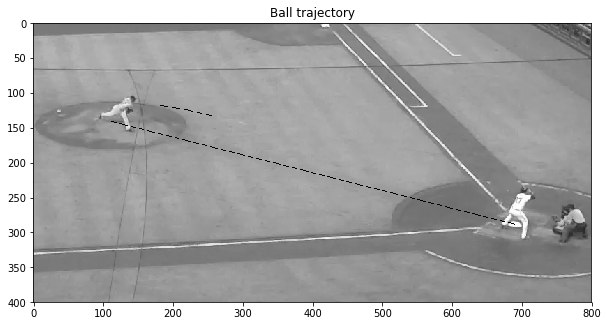

RELEASE FRAME AT  100.0 SPEED in mph 82.4654165101

video: 490770-6080a761-76ed-4b5c-9785-3f1e365ab899.m4v
j 0 3.36290709594 41.0 0.5 0.141897054604
k 0 3.43304944807 41.7612260356 0.0 0.0
metric:  0.0701423521301 0.0182280576483 0.5 0.0
trajectory [[186, 110], [226, 119], [266, 131]]
frames from release frame (using distance from center of base projected) 3.60033497764
k 0 3.40679977104 41.9672491355 0.388888888889 0.114876605417
metric:  0.026249677026 0.00490913996243 0.0 0.388888888889
k 0 3.37533583446 43.1740662898 1.36363636364 0.202883978945
metric:  0.0314639365829 0.0279523625655 0.388888888889 1.36363636364
trajectory [[186, 110], [226, 119], [266, 131], [306, 142], [348, 152]]
frames from release frame (using distance from center of base projected) 5.5821945213


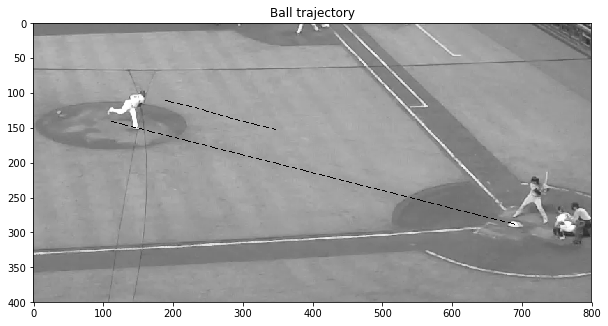

RELEASE FRAME AT  94.0 SPEED in mph 85.6125944517

video: 490770-61464f9e-2e8d-4e3e-928d-0d13a4591d68.m4v
j 0 4.62438160686 17.0660481659 0.0666666666667 0.207496226435
k 0 4.13601375979 11.9268604419 0.625 0.157416872727
metric:  0.488367847063 0.430891914016 0.0666666666667 0.625
k 1 3.22727195109 81.8000611247 0.1875 0.155594827977
metric:  1.39710965576 0.791368760228 0.0666666666667 0.1875
j 0 3.48461659401 44.598206242 0.285714285714 0.185347949996
k 0 3.46671019863 46.9600894377 0.0833333333333 0.0312398334303
metric:  0.0179063953806 0.0502955429612 0.285714285714 0.0833333333333
trajectory [[328, 142], [370, 157], [414, 172]]
frames from release frame (using distance from center of base projected) 6.64898803672
k 0 3.47365212113 46.0135849505 0.0769230769231 0.0312398334303
metric:  0.00694192250274 0.0205701096365 0.0833333333333 0.0769230769231
k 0 3.50036332386 46.9920205992 0.166666666667 0.0644268394256
metric:  0.0267112027277 0.0208213146878 0.0769230769231 0.1666666666

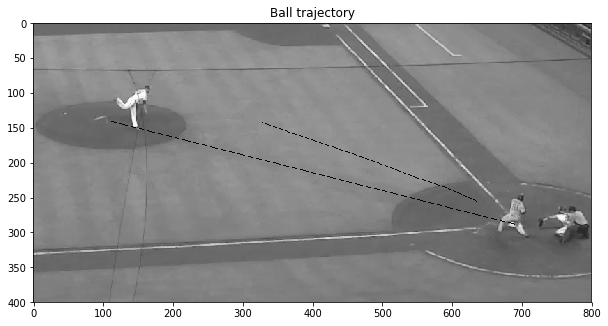

RELEASE FRAME AT  87.0 SPEED in mph 95.9138159376

video: 490770-6164dcdc-686f-4b39-920b-d485ab93ae3f.m4v
j 0 3.39774403616 43.4165866922 0.142857142857 0.0517671792791
k 0 2.88426893862 58.9406481132 1.6 0.430585730821
metric:  0.513475097537 0.263384640616 0.142857142857 1.6
k 1 3.39230191301 42.3231615076 0.2 0.0730405653031
metric:  0.00544212314419 0.0258351490204 0.142857142857 0.2
trajectory [[175, 109], [217, 120], [258, 131]]
frames from release frame (using distance from center of base projected) 3.28844394902
k 0 3.39485841982 43.9004555785 0.0833333333333 0.0232516228105
metric:  0.00255650680934 0.0359288770492 0.2 0.0833333333333
k 0 0.0877140538911 199.767990429 0.211538461538 0.362544237265
metric:  3.30714436593 0.780242793231 0.0833333333333 0.211538461538
k 1 3.41678190272 44.1616349335 0.0769230769231 0.0232516228105
metric:  0.0219234828984 0.00591416860799 0.0833333333333 0.0769230769231
k 0 0.148189877717 247.209425387 0.0625 0.741947268006
metric:  3.268592025 0

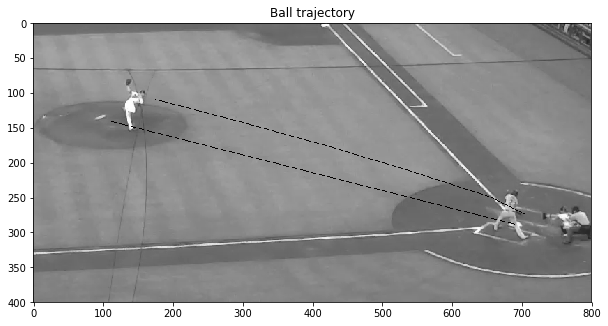

RELEASE FRAME AT  89.0 SPEED in mph 94.7783279374

video: 490770-62c337a4-1897-4fa5-bcb7-d4438612eca7.m4v
j 0 3.40219504534 46.5725240888 0.125 0.0401390720457
k 0 3.38403967656 47.900939448 0.257142857143 0.0445250088345
metric:  0.0181553687815 0.0277325533595 0.125 0.257142857143
trajectory [[176, 118], [221, 130], [267, 142]]
frames from release frame (using distance from center of base projected) 3.24344046011
k 0 3.41576010471 49.8623104158 0.442307692308 0.0232516228105
metric:  0.0317204281538 0.0393357417945 0.257142857143 0.442307692308
trajectory [[176, 118], [221, 130], [267, 142], [315, 155]]
frames from release frame (using distance from center of base projected) 4.22033123376


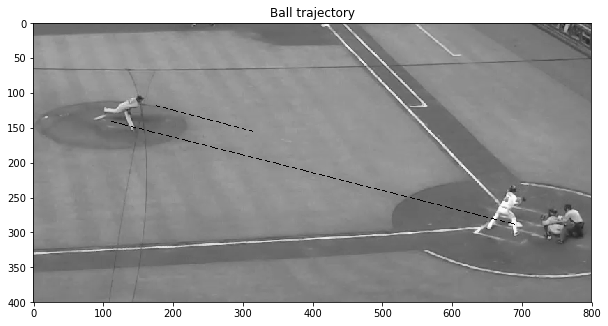

RELEASE FRAME AT  94.0 SPEED in mph 98.0735523162

video: 490770-67d05b6d-c9d5-48ac-be89-2f94cc7a7781.m4v
j 0 3.39596071214 51.6623654124 0.142857142857 0.160375443976
k 0 3.40950307601 52.8866712887 0.333333333333 0.10487693873
metric:  0.0135423638701 0.0231496111689 0.142857142857 0.333333333333
trajectory [[626, 224], [676, 237], [727, 251]]
frames from release frame (using distance from center of base projected) 11.9617962182
trajectory [[626, 224], [676, 237], [727, 251]]
frames from release frame (using distance from center of base projected) 11.9617962182


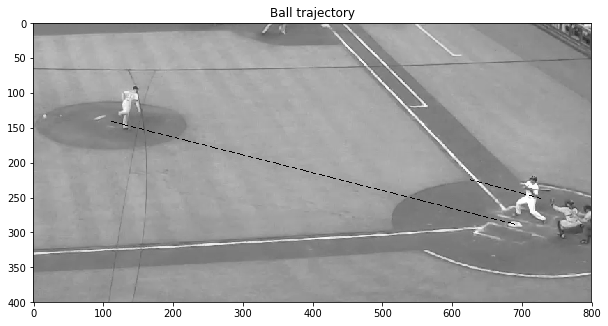

RELEASE FRAME AT  99.0 SPEED in mph 106.925122658

video: 490770-689a9b59-b865-42db-819f-2843fdd195e3.m4v
j 0 3.39571740315 39.7775062064 0.292307692308 0.160900614608
k 0 3.43056806358 38.6005181312 0.285714285714 0.133283328727
metric:  0.0348506604369 0.0304915097553 0.292307692308 0.285714285714
trajectory [[202, 113], [241, 123], [278, 134]]
frames from release frame (using distance from center of base projected) 4.09144202183
k 0 3.44807721844 41.4306649717 0.1 0.10455560198
metric:  0.0175091548573 0.0683104372673 0.285714285714 0.1
k 0 0.115134803191 221.969592512 0.0909090909091 0.344807264433
metric:  3.33294241525 0.81334981741 0.1 0.0909090909091
k 1 3.41989231259 40.040604391 0.272727272727 0.177596167283
metric:  0.0281849058448 0.0347162736884 0.1 0.272727272727
k 0 3.46723423893 40.6355755466 0.625 0.110657221174
metric:  0.0473419263382 0.0146416323016 0.272727272727 0.625
k 0 3.45582455267 42.0594816896 0.153846153846 0.0669389461096
metric:  0.0114096862589 0.0338545

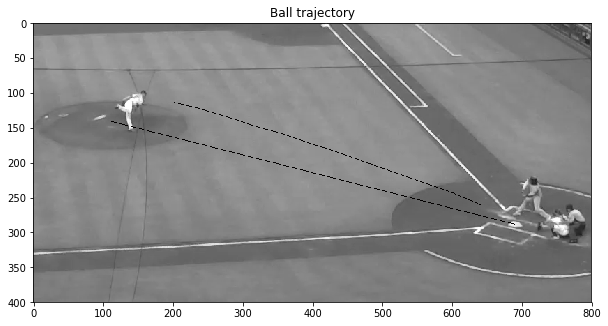

RELEASE FRAME AT  100.0 SPEED in mph 86.1497797364

video: 490770-691da7b3-602b-426c-be3d-1abcfd89e925.m4v
j 0 3.40291863421 44.5112345369 0.0769230769231 0.106571442071
k 0 3.37330949478 45.7219859586 0.166666666667 0.0824215486734
metric:  0.0296091394321 0.0264807268608 0.0769230769231 0.166666666667
trajectory [[161, 106], [204, 118], [249, 128]]
frames from release frame (using distance from center of base projected) 2.90389485293
k 0 3.41373854412 44.6430285711 0.0 0.0
metric:  0.0404290493407 0.0241685526733 0.166666666667 0.0
k 0 3.38915529029 46.930800121 0.114285714286 0.0893838351498
metric:  0.0245832538272 0.0487477636015 0.0 0.114285714286
k 0 3.40420173161 48.15080477 0.230769230769 0.0376166558708
metric:  0.015046441313 0.0253371600913 0.114285714286 0.230769230769
k 0 3.40420173161 48.15080477 0.3 0.0376166558708
metric:  0.0 0.0 0.230769230769 0.3
k 0 3.39179320137 46.4462054424 0.346153846154 0.004219384243
metric:  0.0124085302394 0.0367005078531 0.3 0.346153846154

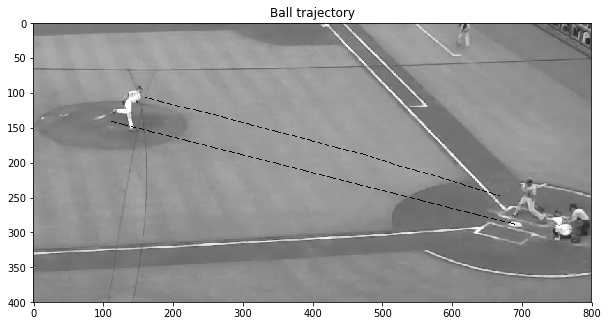

RELEASE FRAME AT  102.0 SPEED in mph 97.8935750916

video: 490770-6a45d5ee-90f6-4439-a4c9-97401ed2724b.m4v
j 0 3.3668694328 49.244289009 0.566666666667 0.191458394668
k 0 3.38155882737 48.3864650496 0.442307692308 0.0232516228105
metric:  0.0146893945646 0.0177285932845 0.566666666667 0.442307692308
trajectory [[176, 117], [224, 128], [271, 139]]
frames from release frame (using distance from center of base projected) 3.19498443976
k 0 3.37211449263 50.3314017289 0.2 0.0587558227157
metric:  0.00944433473528 0.0386426090371 0.442307692308 0.2
k 0 3.40153279378 48.6338359581 0.166666666667 0.0587558227157
metric:  0.0294183011452 0.0349050355044 0.2 0.166666666667
k 0 3.39383511148 50.0849278726 0.28 0.0370201158739
metric:  0.00769768229871 0.0289726266183 0.166666666667 0.28
k 0 3.41202877874 52.4046753639 0.541666666667 0.00999966668667
metric:  0.0181936672632 0.044266040678 0.28 0.541666666667
k 0 3.42414760606 48.4200371747 0.136363636364 0.114876605417
metric:  0.0121188273166 0.

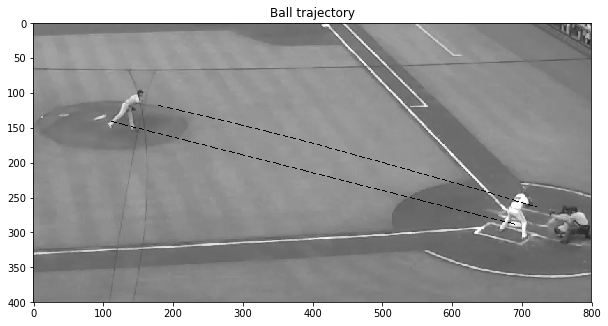

RELEASE FRAME AT  102.0 SPEED in mph 104.939315919

video: 490770-6c1962ee-921f-4d2f-8ed3-f8f571b95917.m4v
j 0 3.40900345077 37.8450789403 0.384615384615 0.165148677415
k 0 3.41253950393 37.3630833845 0.333333333333 0.141897054604
metric:  0.00353605315455 0.012900315288 0.384615384615 0.333333333333
trajectory [[165, 106], [202, 116], [238, 126]]
frames from release frame (using distance from center of base projected) 3.1860348465
k 0 3.42490061797 41.1400048614 0.145833333333 0.10487693873
metric:  0.012361114037 0.0918065393922 0.333333333333 0.145833333333
k 0 3.42154247611 41.6203075433 0.2 0.0727192285533
metric:  0.00335814185166 0.0115401041034 0.145833333333 0.2
k 0 3.45922800488 38.4219989069 0.0909090909091 0.0356991126793
metric:  0.0376855287657 0.0832415992773 0.2 0.0909090909091
k 0 3.44447752196 41.9076365356 0.166666666667 0.068856489301
metric:  0.0147504829146 0.0831742831826 0.0909090909091 0.166666666667
k 0 3.45582455267 42.0594816896 0.0 0.0
metric:  0.0113470307

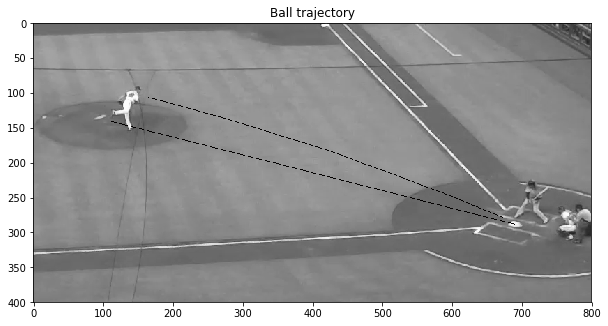

RELEASE FRAME AT  101.0 SPEED in mph 84.8177616102

video: 490770-6d1f7917-51e3-4a37-b265-7399ba5a7219.m4v
j 0 3.36839150164 40.0249921924 0.333333333333 0.133908843984
k 0 3.37199508965 41.5992788399 0.346153846154 0.0445250088345
metric:  0.00360358800498 0.0378440850762 0.333333333333 0.346153846154
trajectory [[157, 105], [196, 114], [237, 123]]
frames from release frame (using distance from center of base projected) 2.89966982851
k 0 2.97857844465 77.0211010049 0.142857142857 0.553031444151
metric:  0.393416644997 0.459897634581 0.346153846154 0.142857142857
k 1 3.41460135668 38.9422649572 0.371428571429 0.0057470631632
metric:  0.0426062670278 0.0682295671702 0.346153846154 0.371428571429
k 0 0.921307265618 83.5014969926 0.0909090909091 0.163423053588
metric:  2.49329409106 0.533633930411 0.371428571429 0.0909090909091
trajectory [[157, 105], [196, 114], [237, 123], [274, 134]]
frames from release frame (using distance from center of base projected) 3.9175739751


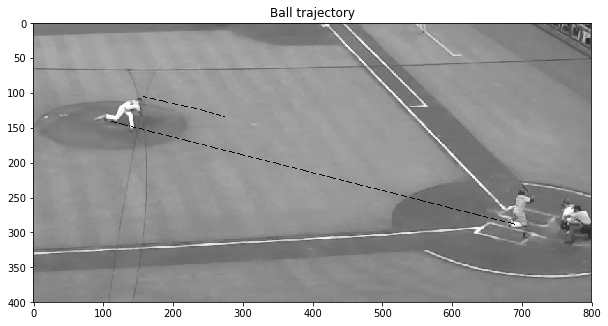

RELEASE FRAME AT  109.0 SPEED in mph 82.2284058319

video: 490770-6fedab77-fd63-4bee-a463-07661cf7a5f8.m4v
j 0 3.39945720139 47.0558179187 0.380952380952 0.106392854699
k 0 3.39414692937 48.0234317807 0.230769230769 0.0820074455262
metric:  0.00531027202294 0.0201487862517 0.380952380952 0.230769230769
trajectory [[193, 122], [238, 134], [285, 146]]
frames from release frame (using distance from center of base projected) 3.59807105498
k 0 3.41076014638 45.1248268695 0.3 0.0820074455262
metric:  0.0166132170076 0.0642352583348 0.230769230769 0.3
k 0 0.0309818188582 242.116191115 0.211538461538 0.611254226358
metric:  3.37977832752 0.813623258066 0.3 0.211538461538
k 1 3.42705551386 47.9400667501 0.25 0.068674902232
metric:  0.016295367481 0.0587241543751 0.3 0.25
k 0 3.42282485551 46.8401537145 0.615384615385 0.0694533259953
metric:  0.00423065834845 0.0234822678474 0.25 0.615384615385
k 0 3.44695123368 48.2312139594 0.257142857143 0.004219384243
metric:  0.0241263781703 0.0288414935207

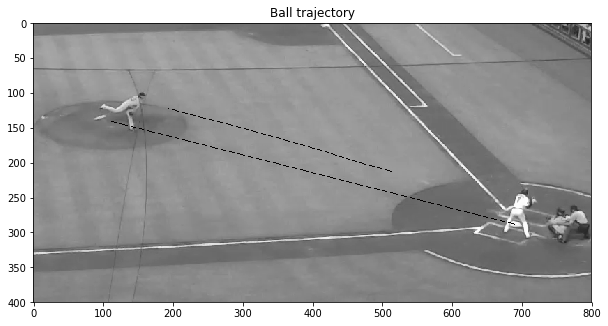

RELEASE FRAME AT  107.0 SPEED in mph 97.1527123979

video: 490770-702d5e63-10a8-411f-975b-cb2d30dcc13f.m4v


KeyboardInterrupt: 

In [130]:
path = "/Volumes/Nina Backup/videos/atl/2017-05-22/side view/"
l = os.listdir(path)
for BASE in l[30:]:
    if BASE[-4:]!=".m4v":
        continue
    print("video:", BASE)
    frame_indizes, location, candidates_per_frame, first_move_frame = detect_ball(path+BASE, joints_array = None, plotting=False, min_area=30) #400
    #print(" RELEASE FRAME FOUND", first_move_frame)
    if first_move_frame ==0:
        print("NO BALL TRAJECTORY FOUND")

#example ="#9 RHP Ryan King (2)" # #9 RHP Ryan King (2) #9 RHP Ryan King # #48 RHP Tom Flippin # 8 RHP Cole Johnson #15 Brandon Coborn # #10 Matt Glomb #26 RHP Tim Willites" (willites camera moves) #00 RHP Devin Smith
#BASE = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/"+example+".mp4" #"data/Matt_Blais/" # für batter: pic davor, 03 streichen und (int(idx+1))
#joints_path = "/Volumes/Nina Backup/high_quality_outputs/"+example+".json"

# First Movement testing

In [ ]:
import ast
#joints_path = "/Volumes/Nina Backup/Nina's Pitch/40mph_1us_1.2f_170fps_40m_sun.json"
path = "/Volumes/Nina Backup/CENTERFIELD bsp videos/"
csv = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/csvs/csv_gameplay.csv", delimiter = ";")
detected_first_move = []
label_first_move = []
label_release_frame =[]
j = 0
for bsp in os.listdir(path):
    if bsp[-4:]!=".mp4":
        continue
    BASE = path+ bsp # "/Volumes/Nina Backup/CENTERFIELD bsp videos/3d69a818-568e-4eef-9d63-24687477e7ee.mp4" # minarea 50
    print(bsp)
    joints_path = "/Volumes/Nina Backup/outputs/new_videos/cf/490770_"+ bsp[:-4] + "_pitcher.json" #3d69a818-568e-4eef-9d63-24687477e7ee_pitcher.json"
    if not os.path.exists(joints_path):
        print("file existiert nicht", joints_path)
        continue
    joints = from_json(joints_path)[:,:12,:]
    print(joints.shape)
    
    for i in open(BASE+".dat").readlines():
        datContent=ast.literal_eval(i)
    label_release_frame.append(datContent["pitch_frame_index"])
    label_first_move.append(datContent["first_movement_frame_index"])
    assert dic["label"][j] == label_first_move[-1]
    #if dic["position"][j]!= "Windup":
     #   j+=1
    #  continue
    print(dic["position"][j])
    j+=1
    #for name in ["40mph_1us_1.2f_170fps_40m_sun.avi","40mph_10us_6f_100fps_40m_cloudy.avi", "40mph_10us_11f_100fps_noisy.avi"]:
    #    frame_indizes, location, candidates_per_frame = detect_ball("/Volumes/Nina Backup/Nina's Pitch/"+name, joints_array=None)
    #import sys
    #sys.exit()
    frame_indizes, location, candidates_per_frame, first_move_frame = detect_ball(BASE, joints_array = joints, plotting=False, min_area=50) #400
    detected_first_move.append(first_move_frame)
    
    print("detected", detected_first_move[-1], "label", label_first_move[-1])
    

### ONLY DETECTION

In [ ]:
def polyarea_bbox(bbox):
    x = bbox[:,0]
    y = bbox[:,1]
    # print("Pearson", stats.pearsonr(x,y))
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def poly_factor(bbox):
    x = bbox[:,0]
    y = bbox[:,1]
    # print("Pearson", stats.pearsonr(x,y))
    area = 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
    length = np.linalg.norm(bbox[0,:2]-bbox[2,:2])
    print(area, length)
    return length/(area+0.0000001)

def overlap(box1, box2):
    if box1[0]> box2[2] or box2[0]>box1[2] or box1[1]>box2[3] or box2[1]>box1[3]:
        return False
    else: return True

def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

out = np.array([[1098, 867, 1139, 905], [1074, 870, 1114, 908], [1050, 873, 1089, 911]])
x = out[:,[0, 2]].flatten()
y = out[:,[1,3]].flatten()
plt.scatter(x,y)
plt.show()
print(PolyArea(x,y))
print(np.linalg.norm(out[0,:2]-out[2,:2]))
print(overlap([1113, 617, 1146, 645], [1014, 655, 1047, 672]))

# first movement evaluation

### open json file with all results and csv with standard deviations

In [15]:
import pandas as pd
with open("all_first_move_tests.json", "r") as infile:
    dic = json.load(infile)
print(dic.keys())
df = pd.read_csv("first_move_evaluation.csv")
print(df.columns.tolist())
print(df["Unnamed: 0"])

dict_keys(['label', 'every_4', 'every_2', 'release', 'every_5', '3_refined_nograd', '3_refined', 'every_3', 'position'])
['Unnamed: 0', 'Unnamed: 0.1', 'every_2', 'every_3', 'every_4', 'every_5', 'label', 'every_3_refined']
0    0
1    1
2    2
3    3
4    4
Name: Unnamed: 0, dtype: int64


### save recent output in dictionary

In [ ]:
a = detected_first_move.copy()
b = label_release_frame.copy()[:-1]
c = label_first_move.copy()
print(len(a),len(b),len(c))
assert(c==dic["label"])
d = np.array([a,b,c])
print(d.shape)

np.save("first_move_outputs_every_3_ref_without_gradient.npy", a)

dic["3_refined_nograd"]= np.array(a).astype(np.float32).tolist()
with open("all_first_move_tests.json", "w") as outfile:
    json.dump(dic, outfile)

### histograms of dictionary

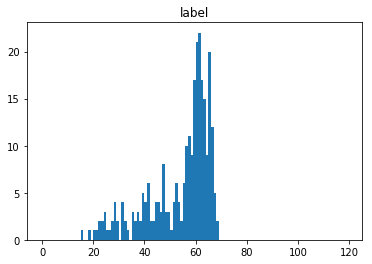

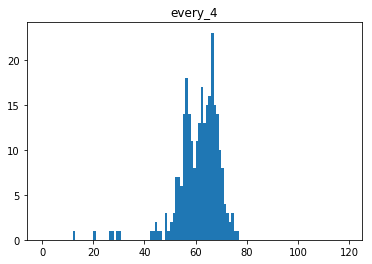

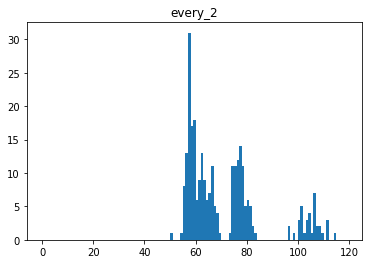

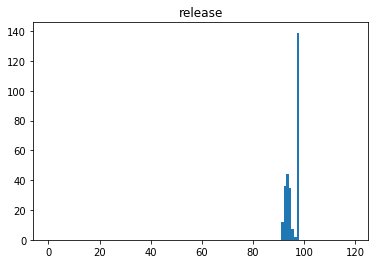

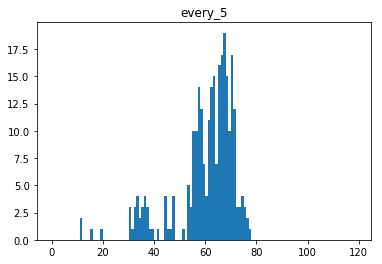

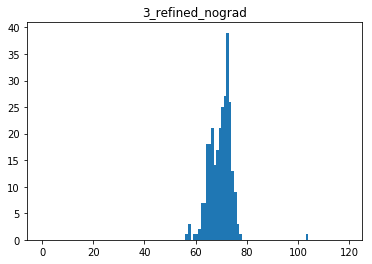

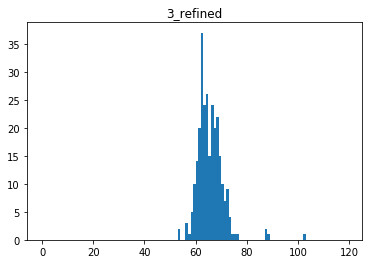

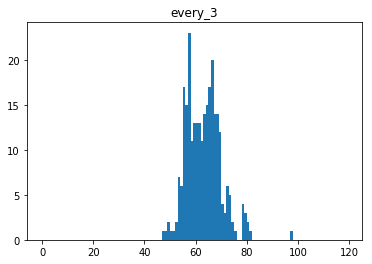

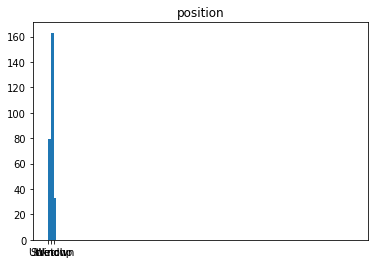

In [16]:
for i in list(dic.keys()):
    plt.hist(dic[i], bins=np.arange(120))
    plt.title(i)
    plt.show()

### form csv with standard deviations and outliers

In [ ]:
print(df)
new_column = "3_refined_nograd"
new_column_values = dic[new_column]
a = np.round(np.mean(new_column_values),3)
b = np.round(np.std(new_column_values),3)
c = np.sum(np.absolute(new_column_values-np.mean(new_column_values)) > 3*b)/275
d = np.sum(np.absolute(new_column_values-np.mean(new_column_values)) > 2*b)/275
e = np.sum(np.absolute(new_column_values-np.mean(new_column_values)) > 1*b)/275
l = [e,d,c,b,a]
print(l)
d = pd.Series(l)
df["every_3_refined"]=d
print(df)
df.to_csv("first_move_evaluation.csv")

In [ ]:
# dic = {"every_2":[], "every_3":[], "every_4":[], "every_5":[], "label":[]}
i=1
for d in outputs:
    i+=1
    rel_detect = np.array(d[1]-d[0])
    std = np.std(rel_detect)
    more_than_2std = np.absolute(rel_detect-np.mean(rel_detect))> 3*std
    #print(more_than_2std)
    print(np.sum(more_than_2std))
    dic["every_%d"%i].append(np.mean(rel_detect))

d = outputs[1]
rel_lab = np.array(d[1]-d[2])
std_2 = np.std(rel_lab)
more_than_2std_2 = np.absolute(rel_lab-np.mean(rel_lab))> 3*std_2
print(np.sum(more_than_2std_2))
dic["label"].append(np.mean(rel_lab))

print(dic)

In [ ]:

for key in dic.keys():
    for i in range(len(dic[key])):
        dic[key][i] = round(dic[key][i], 3)
print(dic)
df = pd.DataFrame.from_dict(dic)
df = df.rename(index = {0: "percentage >1*std", 1: "percentage >2*std", 2: "percentage >3*std", 3: "std", 4: "mean"}) 
df.to_csv("first_move_evaluation.csv")
#with open("dic_with_first_move_evaluation.json", "w") as outfile:
 #   json.dump(dic, outfile)

### For position and gradient retrieval

In [ ]:
arr = np.array(outputs[2])
j=0
#old = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/cf_data_cut.csv")
cf_list = old["Pitching Position (P)"].values
print(cf_list)
position  = []
cf_play_list = old["play_id"].values.tolist()
refined = []
for bsp in (os.listdir(path)):
    if bsp[-4:]!=".mp4":
        continue
    BASE = path+ bsp # "/Volumes/Nina Backup/CENTERFIELD bsp videos/3d69a818-568e-4eef-9d63-24687477e7ee.mp4" # minarea 50
    # print(bsp)
    joints_path = "/Volumes/Nina Backup/outputs/new_videos/cf/490770_"+ bsp[:-4] + "_pitcher.json" #3d69a818-568e-4eef-9d63-24687477e7ee_pitcher.json"
    if not os.path.exists(joints_path):
        print("file existiert nicht", joints_path)
        continue
    joints = from_json(joints_path)[:,:12,:]
    # print(joints.shape)
    
    #print(bsp, cf_play_list)
    if bsp[:-4] in cf_play_list:
        position.append(cf_list[cf_play_list.index(bsp[:-4])])
        # print(pos)
    else: 
        position.append("Unknown")
    continue
    
    for i in open(BASE+".dat").readlines():
        datContent=ast.literal_eval(i)
    rel_frame = datContent["pitch_frame_index"]
    label_first_move = datContent["first_movement_frame_index"]

    assert(rel_frame == arr[1,j])
    assert(label_first_move == arr[2,j])
    first_move_frame = arr[0,j]
    range_joints = joints[first_move_frame -10: first_move_frame +10]
    grad = np.gradient(range_joints, axis = 0)
    plt.plot(grad[:,:,1])
    #plt.show()
    mean_gradient = np.mean(grad[:, [7,8,10,11],1], axis = 1)
    plt.plot(mean_gradient, c = "black")
    plt.show()
    print("previous", first_move_frame, "new", first_move_frame-10+np.argmin(mean_gradient))
    refined.append(first_move_frame-10+np.argmin(mean_gradient))
    j+=1
    
print(position, len(position))

### plot comparisons

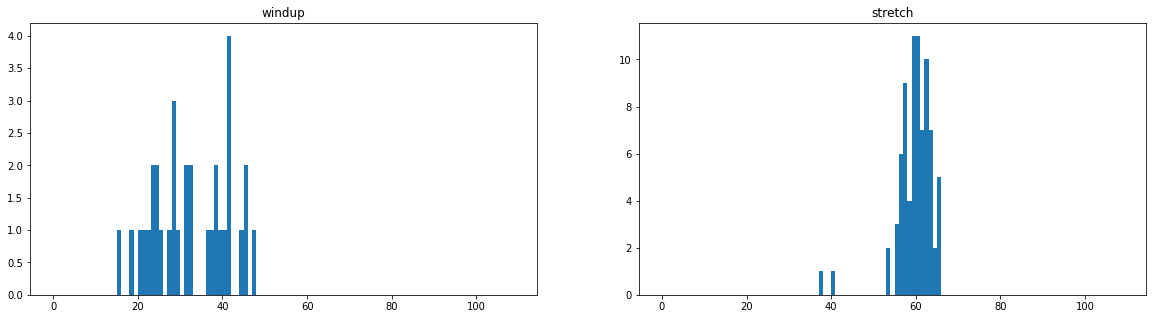

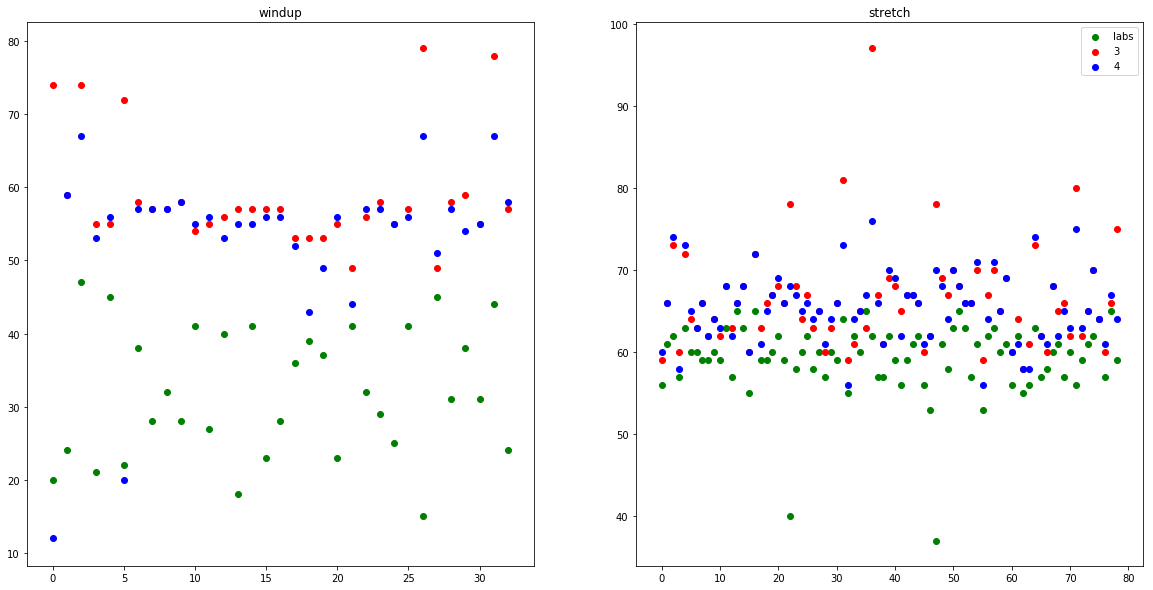

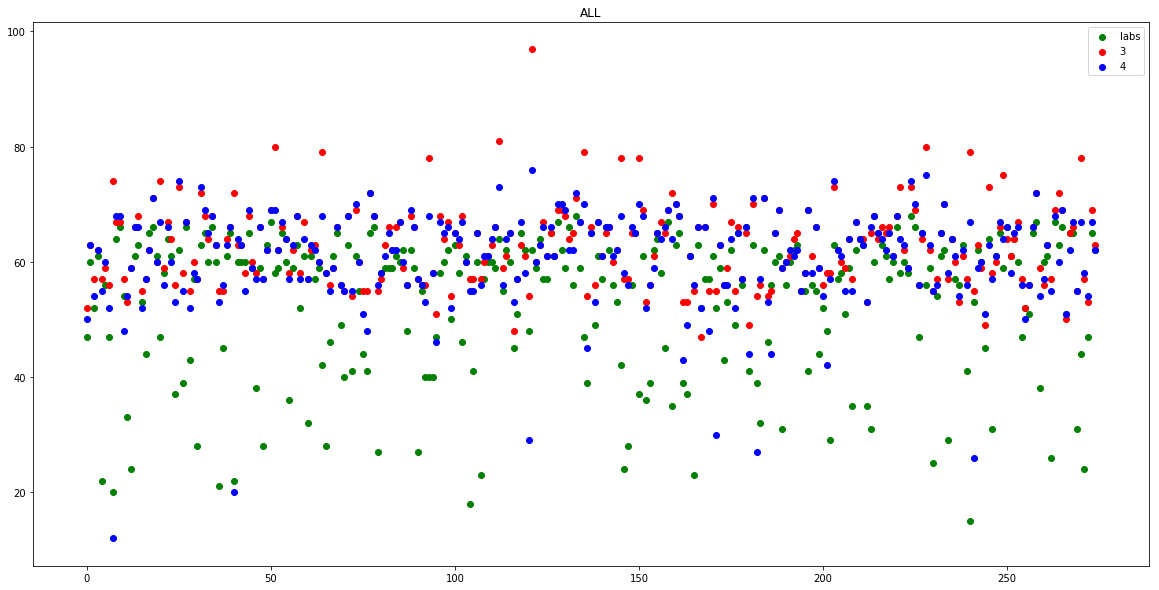

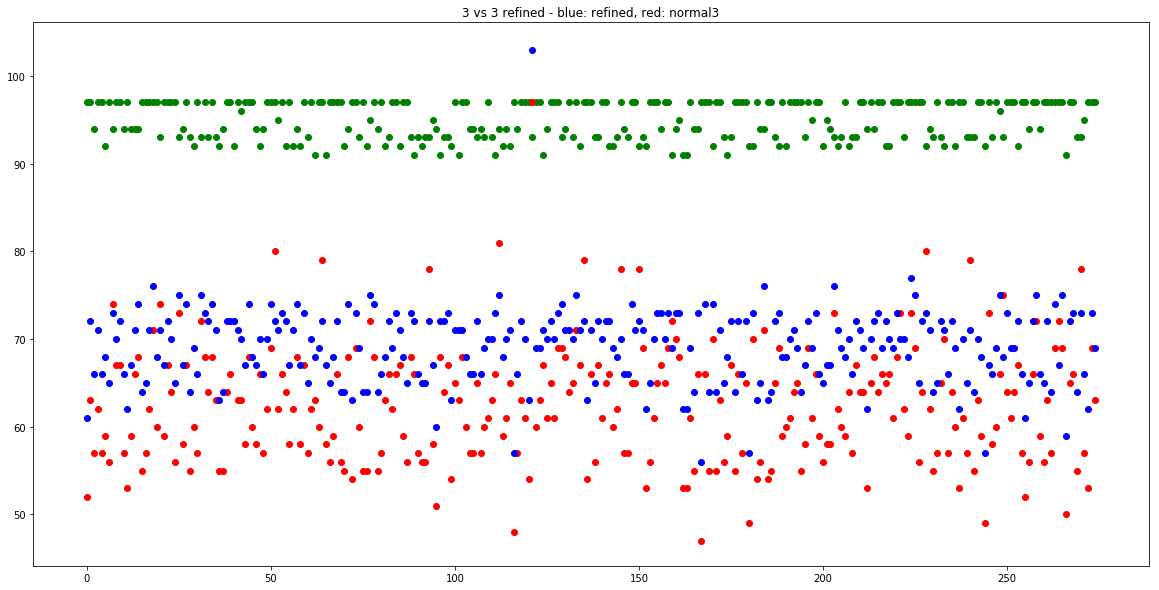

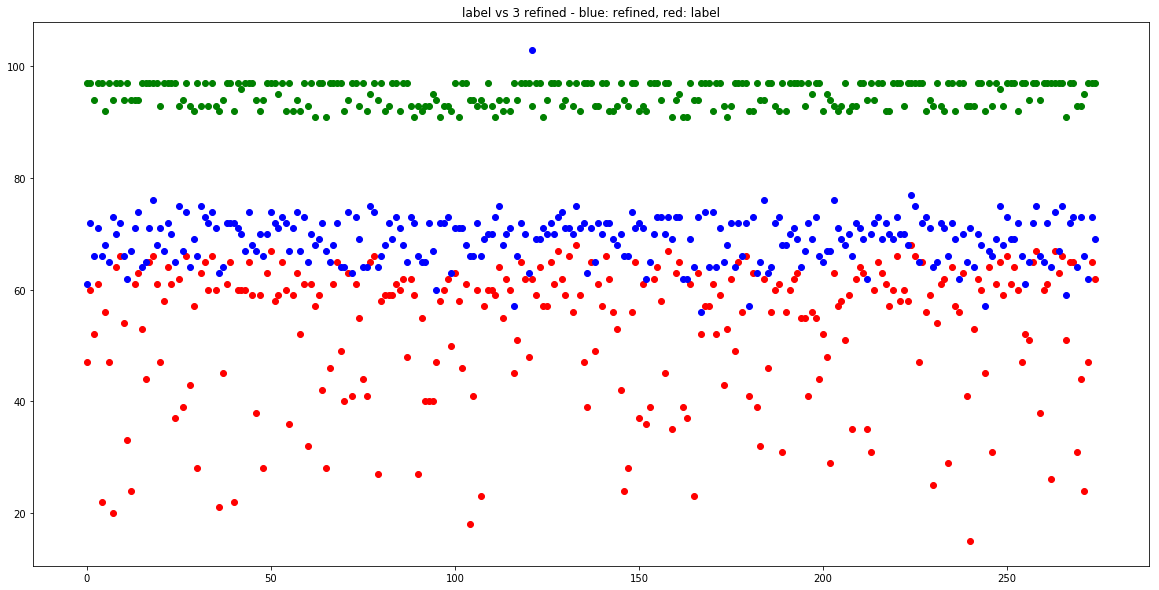

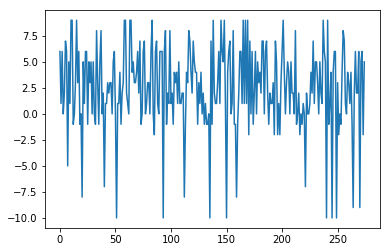

2.44727272727


In [17]:
# print(np.array(outputs).shape)
# new = np.array(outputs)[:, 0, :]
#new = np.append(np.array([outputs[0][1], outputs[0][2]]), np.array(new), axis = 0)
def scatter_plot(l):
    plt.scatter(np.arange(len(l[0])),l[0], label = "labs", c = "green")
    plt.scatter(np.arange(len(l[0])), l[1], label = "3", c = "red")
    plt.scatter(np.arange(len(l[0])), l[2], label = "4", c="blue")

# SHOW LABELS SEPERATED BY WINDUP AND STRETCH
inds = np.where(np.array(dic["position"])=="Windup")[0]
inds_st = np.where(np.array(dic["position"])=="Stretch")[0]
vals_wind = np.array(dic["label"])[inds]
vals_stretch = np.array(dic["label"])[inds_st]

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(vals_wind, bins= np.arange(0, 110))
plt.title("windup")
plt.subplot(1,2,2)
plt.hist(vals_stretch, bins= np.arange(0, 110))
plt.title("stretch")
plt.show()

# WINDUP
every_3_wind = np.array(dic["every_3"])[inds]
every_4_wind =  np.array(dic["every_4"])[inds]
fig = plt.figure(figsize = (20,10))
# plt.style.use('ggplot')
plt.subplot(1,2,1)
scatter_plot([vals_wind, every_3_wind, every_4_wind])
plt.title("windup")
# plt.legend()
# plt.show()

# STRETCH
every_3_set = np.array(dic["every_3"])[inds_st]
every_4_set =  np.array(dic["every_4"])[inds_st]
# plt.style.use('ggplot')
plt.subplot(1,2,2)
scatter_plot([vals_stretch, every_3_set, every_4_set])
plt.title("stretch")
plt.legend()
plt.show()

# ALL
fig = plt.figure(figsize = (20,10))
# plt.style.use('ggplot')
scatter_plot([dic["label"], dic["every_3"], dic["every_4"]])
plt.legend()
plt.title("ALL")
plt.show()
#plt.grid(True)
#from matplotlib2tikz import save as tikz_save
#tikz_save('test.tex')

# COMPARE 3 and 3 refined_nograd:
fig = plt.figure(figsize = (20,10))
scatter_plot([dic["release"], dic["every_3"], dic["3_refined_nograd"]])
plt.title("3 vs 3 refined - blue: refined, red: normal3")
plt.show()

# COMPARE labels and 3 refined_nograd:
fig = plt.figure(figsize = (20,10))
scatter_plot([dic["release"], dic["label"], dic["3_refined_nograd"]])
plt.title("label vs 3 refined - blue: refined, red: label")
plt.show()

# DIFFERENCE FROM EACH OTHER
label_error = np.array(dic["3_refined"])-np.array(dic["every_3"])
plt.plot(label_error)
plt.show()
print(np.mean(label_error))

In [ ]:
for i in range(7):
    for j in range(275):
        new[i,j] = float(new[i,j])

#dic = {"release": new[0].tolist(), "label": new[1].tolist(), "every_2":new[2].tolist(), "every_3":new[3].tolist(), "every_4":new[4].tolist(), "every_5":new[5].tolist(), "3_refined":new[6].tolist()}
dic["position"] = position[:275]
with open("all_first_move_tests.json", "w") as outfile:
    json.dump(dic, outfile)

# Stabilization

In [ ]:
def optical_flow(file):
    cap = cv2.VideoCapture(file)
    arr = []
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100,
                           qualityLevel = 0.3,
                           minDistance = 7,
                           blockSize = 7 )
    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                      maxLevel = 2,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    # Create some random colors
    color = np.random.randint(0,255,(100,3))
    # Take first frame and find corners in it
    ret, old_frame = cap.read()
    print(old_frame.shape)
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)
    move = [0,0]
    for i in range(100): #while(1):
        ret,frame = cap.read()
        if frame is None:
            break
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]
        # draw the tracks
        for j,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (a,b),(c,d), color[j].tolist(), 2)
            frame = cv2.circle(frame,(a,b),5,color[j].tolist(),-1)
        img = cv2.add(frame,mask)
        move+= np.mean(good_new-good_old, axis = 0)
        mean_move = np.around(move).astype(int)
        print(np.mean(good_new-good_old, axis = 0))
        print(mean_move)
        if i>70:
            plt.imshow(img)
            plt.show()
        new = np.roll(frame, -mean_move[0], axis = 0)
        new = np.roll(new, -mean_move[1], axis = 1)
        arr.append(new[20:-20, 20:-20, :])
        #k = cv2.waitKey(30) & 0xff
        #if k == 27:
         #   break
        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1,1,2)
    cv2.destroyAllWindows()
    cap.release()
    return np.array(arr)
    
example ="#9 RHP Ryan King (2)" #9 RHP Ryan King # #48 RHP Tom Flippin # 8 RHP Cole Johnson #15 Brandon Coborn # #10 Matt Glomb #26 RHP Tim Willites" (willites camera moves) #00 RHP Devin Smith
BASE = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/"+example+".mp4" #"data/Matt_Blais/" # für batter: pic davor, 03 streichen und (int(idx+1))
array = optical_flow(BASE)
from skvideo import io
io.vwrite("stabilize.mp4", array)

# Person detector opencv

In [ ]:
# construct the argument parse and parse the arguments

 
# initialize the HOG descriptor/person detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

for imagePath in ["/Volumes/Nina Backup/Nina's Pitch/bsp_images/cloudy_ball.jpg"]:
    # load the image and resize it to (1) reduce detection time
    # and (2) improve detection accuracy
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=min(400, image.shape[1]))
    orig = image.copy()
    tic = time.time()
    # detect people in the image
    (rects, weights) = hog.detectMultiScale(image, winStride=(2, 2),
        padding=(4, 4), scale=1.09)
    print("time", time.time()-tic)
    # draw the original bounding boxes
    for (x, y, w, h) in rects:
        cv2.rectangle(orig, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # apply non-maxima suppression to the bounding boxes using a
    # fairly large overlap threshold to try to maintain overlapping
    # boxes that are still people
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
    pick = non_max_suppression(rects, probs=None, overlapThresh=0.65)

    # draw the final bounding boxes
    for (xA, yA, xB, yB) in pick:
        cv2.rectangle(image, (xA, yA), (xB, yB), (0, 255, 0), 2)

    # show some information on the number of bounding boxes
    filename = imagePath[imagePath.rfind("/") + 1:]
    print("[INFO] {}: {} original boxes, {} after suppression".format(
        filename, len(rects), len(pick)))

    # show the output images
    plt.imshow(orig)
    plt.show()
    plt.imshow(image)
    plt.show()

In [87]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)
def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


[580 148] [148 580]


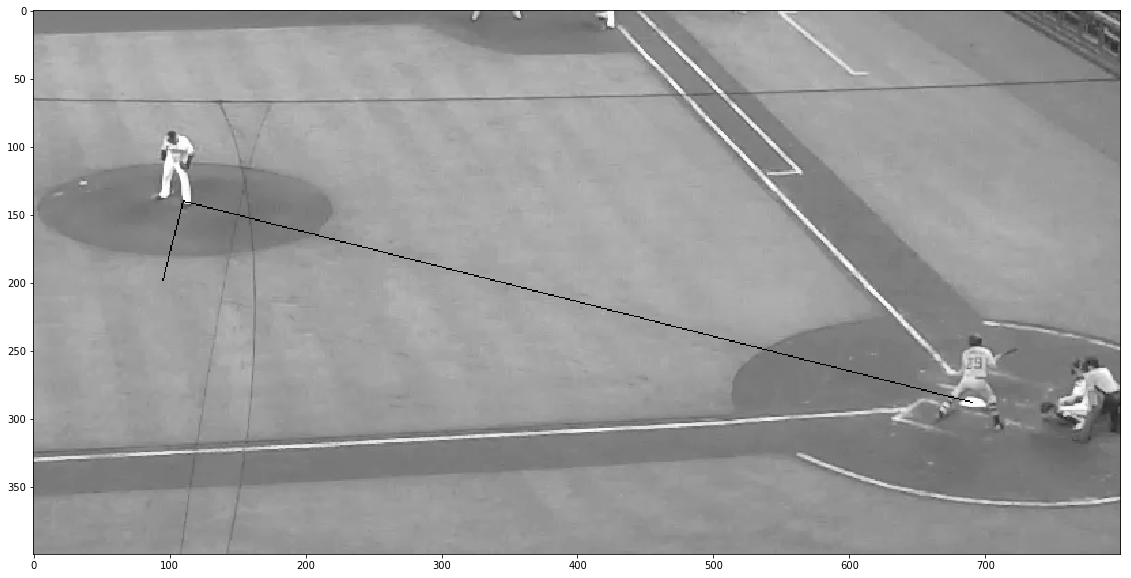

In [83]:
path = "/Volumes/Nina Backup/videos/atl/2017-05-22/side view/"
p1 = np.array([110, 140])
p2 = np.array([690, 288])
vec = (p2-p1)
print(vec, np.array([vec[1], vec[0]]))
p3 = (p1+0.1*np.array([-vec[1], vec[0]])).astype(int)
for BASE in os.listdir(path)[:1]:
    if BASE[-4:]!=".m4v":
        continue
    cap = cv2.VideoCapture(path+BASE)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)[400:800, 600:1400]
    # frame[140, 110]=0   #[288, 690]=0 #280:290, 680:700] = 0
    frame = cv2.line(frame, tuple(p2), tuple(p1), color = 1)
    frame = cv2.line(frame, tuple(p1), tuple(p3), color = 1)
    plt.figure(figsize = (20,10))
    plt.imshow(frame)
    plt.gray()
    plt.show()

In [35]:
distance = np.linalg.norm(np.array([140, 110])- np.array([288, 690]))
print(distance)


598.584998141


In [88]:
p = np.array([300, 100])
dist = np.cos(angle_between(p-p1, p2-p1)) * np.linalg.norm(p-p1)
print(dist)
print(distance_projected(p, p1, p2))

174.210847789
174.210847789


In [72]:
print(np.cross(np.array(690,288)-np.array(110, 140), np.array(110, 140)- np.array(300,500)))
#/np.linalg.norm(np.array(110, 140)-np.array(690,288))

TypeError: data type not understood

In [97]:
first_bbox = [-1,1]
second_bbox = [-2,2]
angle = np.arctan((first_bbox[1]-second_bbox[1])/(first_bbox[0]-second_bbox[0]))
print(angle)

-0.785398163397


In [ ]:
sv = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/sv_data.csv")
rel = sv["pitch_frame_index"].values
print(np.unique(sv["pitch_frame_index"].values))
plt.hist(rel)